In [1]:
%load_ext autoreload 
%autoreload 2
%load_ext rpy2.ipython

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [2]:
import pandas as pd
import data
from IPython.display import Markdown
import logisticRegression
import numpy as np
import Model
import Trackers.ModelTracker as ModelTracker
import plot_tools
import FeatureTools
import Trackers.FeatureTracker as FeatureTracker
import Trackers.DataTracker as DataTracker
import model_config
import examples_files.graph_examples as ex

In [3]:
df = data.get_data()
data_info_instance = data.DataInfo.get_instance()
model_tracker = ModelTracker.ModelTracker()
data_tracker = DataTracker.X_tracker()
cols_to_scale = []

# Title

## Task

For the prediction task, the underlying problem is to the find the subset of customers with a probability of having a caravan insurance policy above some boundary probability. The known policyholders can then be removed and the rest receives a mailing. The boundary depends on the costs and benefits such as of the costs of mailing and benefit of selling insurance policies. To approximate this problem, we want you to find the set of 800 customers in the test set that contains the most caravan policy owners.

Le but est de maximiser le nombre d’individus avec CARAVAN = 1 parmi les 800 clients ayant les probabilités prédites les plus élevées.

## Régression logistique

J'ai décider d'utiliser une régression logistique puisque la variable cible est binaire (si CARAVAN = 0 ou 1). De plus, ce modèle est facile à interpréter, car il exprime l’effet de chaque variable explicative a l'aide des coefficients comparables à ceux d’une régression linéaire.

$$\text{logit } p = \ln \frac{p}{1-p} = \beta_0 + \beta_1x_1 + ... + \beta_nx_n = z$$
$$ e^z = \frac{p}{1-p} \iff p = \frac{e^z}{1 + e^z} $$
$$p = P(\text{CARAVAN} = 1 | X = x)$$

Je vais commencer par trouver qu'elles sont mes variables significatives. Je vais utiliser le $OR$ avec des intervalles de confiances.

$$\text{odds } = \frac{p}{1-p}$$

l'odds ratio associé a une variable d'une régression logistique est donné par

$$OR = e^{\beta}$$

Le odds-ratio permet de mesurer l'effet d'une variable sur la probabilité qu'un évenements se produise (CARAVAN = 1).

$$OR > 1 \to \text{augmente les chances que CARAVAN = 1}$$
$$OR < 1 \to \text{diminue les chances que CARAVAN = 1}$$
$$OR = 1 \to \text{aucun effet sur les chances que CARAVAN = 1}$$

Pour calculer un intervalle de confiance, j'ai besoin de l'écart-type des coefficients $\beta$. 

Mais puisque les coefficients de la régression logistique dépend des rélations entres les variables, je ne peut pas utiliser des variances indépendantes. Donc, je dois utiliser une matrice de covariance, qui est l'inverse de la matrice de Fisher Information. 

$$\mathcal I(\beta) = \mathbf{X}^\top \mathbf{W}\mathbf{X}, \quad \mathbf{W} = \mathrm{diag}(p_i(1-p_i))$$

$$\mathrm{Cov}(\beta) = \mathcal I(\beta)^{-1} = \begin{bmatrix}
\mathrm{Var}(\beta_1) & \mathrm{Cov}(\beta_1,\beta_2) & \cdots \\
\mathrm{Cov}(\beta_2,\beta_1) & \mathrm{Var}(\beta_2) & \cdots \\
\vdots & & \ddots
\end{bmatrix}$$

Cette matrice contient : 
- sur la diagonale : les variances indépendantes de chaque coefficient
- hors diagonale : les covariances entre paires des variables

$$\mathbf{X} =  \begin{bmatrix}
\mathbf{x}_1, \mathbf{x}_2 \ldots \mathbf{x}_n
\end{bmatrix}^\top
$$

$$p_i = P(\text{CARAVAN} = 1 | \mathbf{x}_i) = \sigma(\mathbf{x}_i  \cdot \beta) = \dfrac{e^{\mathbf{x}_i \cdot \beta}}{1 + e^{\mathbf{x}_i  \cdot \beta}}$$

#### **Loss  function :** 
$$\ell(\beta) = \sum_{i=1}^{n} \Big[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \Big], \quad y_i \in \{0, 1\} \text{ est la valeur observée du target}$$

$$\mathcal L(\boldsymbol{\beta}) = -\ell(\boldsymbol{\beta})$$

$y_i$ suit une loi de Bernoulli donc

$$\text y_i \sim Bernoulli(p_i) \implies Var(y_i) = p_i(1 - p_i)$$

$$ W = \mathrm{diag}(p_i(1 - p_i)) =
\begin{bmatrix}
p_1(1-p_1) & 0 & \cdots & 0 \\
0 & p_2(1-p_2) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & p_n(1-p_n)
\end{bmatrix}$$

#### **Gradient :**

$$\frac{\partial \ell}{\partial \beta} = \mathbf{X}^\top(\mathbf{y}-\mathbf{p})$$

C'est un vecteur de dérivées partielles, une pour chaque coefficient du modèle. Le but est d'atteindre un point où le gradient est nul, donc $$\nabla \ell(\beta) \approx 0$$ La signe du gradient (si $\nabla \ell(\beta) > 0$ ou  $\nabla \ell(\beta) < 0$) détermine le sens de mise à jour (+ ou -) de chaque coefficient $\beta_i$ afin de se rapprocher de l'optimum. 

On prend des "pas" successifs vers l'optimum. Les nombres de pas est le nombre d'itérations,  c’est-à-dire au nombre de fois où l’on applique la mise à jour $$\mathbf{\beta_{\text{nouveau}}} = \mathbf{\beta} - \eta \nabla f(\mathbf{\beta})$$ Le paramètre 
$\eta$ (learning rate) est la taille du pas. Chaque répétition de cette mise à jour permet de se rapprocher progressivement de l’optimum.

Le gradient ascent est tout simplement des "pas" positifs au lieu de négatif. Le gradient ascent maximise la fonction, tandis que le gradient descent la minimise.

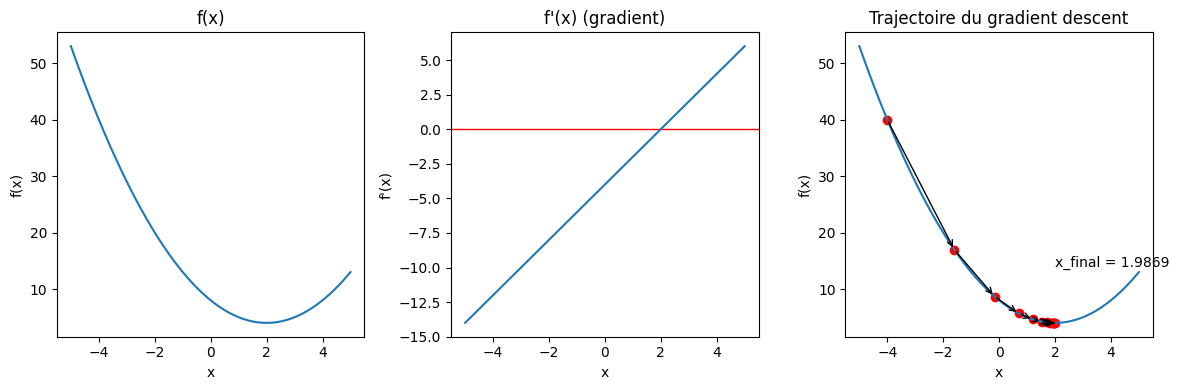

In [4]:
ex.gradient_descent()

Les variables représentent les dimensions de l’espace des paramètres : un modèle avec deux variables est donc à un espace 2D.

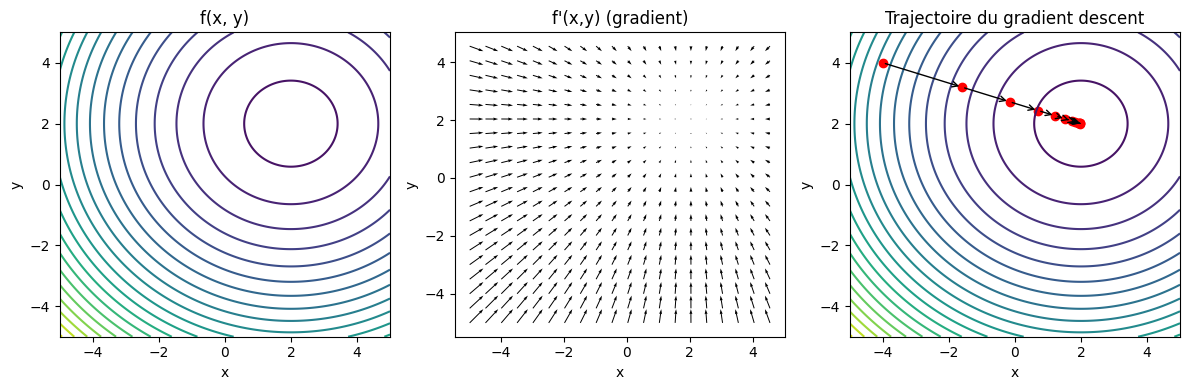

In [5]:
ex.gradient_descent_2D()

La hessienne (dérivées seconde) de la fonction de perte : 
$$\nabla^2 \mathcal L(\boldsymbol{\beta}) = -\frac{\partial^2 \ell}{\partial \beta\, \partial \beta^\top} = \mathbf{X}^\top \mathbf{W}\mathbf{X}$$

qui est la matrice d'information de Fisher. Elle décrit la courbure autour de $\beta_i$ de la fonction de perte au voisinage de l'optimum, donc la sensibilité de la perte aux variations des coefficients $\beta_i$.

In [6]:
vars_dict = data.get_vars_cols_translated()

# **Data preprocessing**

## Variables nominales.

La régression logistique est un modèle linéaire. $$\beta_0 + \sum_i \beta_i x_i$$ Les variables **MOSTYPE_Customer_Subtype** et **MOSHOOFD_Customer_main_type** sont nominales puisqu'elles n'ont pas d'ordre. Si on les laisse encoder avec le codage (1-2-3,..) le modèle impose une relation linéaire entre les catégories. 

En d'autre mots, un seul coefficient $\beta$ est associé pour à toute les variables et va donc varier selon celle-ci. 

On doit "one-hot encode"  ces variables pour éviter cette effet. Cela force le modèle a attribuer un coefficient distinct à chaque modalité et donc va traiter les catégories indépendamment les unes des autres. La catégorie qui est "dropped" devient la catégorie de référence, chaque coefficient mesure l'effet d'une catégorie par rapport à la catégorie supprimée.

In [7]:
categorical_non_ordinales = ['MOSTYPE', 'MOSHOOFD']
df_encoded = pd.get_dummies(df, columns=categorical_non_ordinales, prefix=categorical_non_ordinales, dtype=int, drop_first=True)
X_base_one_hot = df_encoded.copy()
feature_tracker = FeatureTracker.FeatureTracker(X_base_one_hot)
X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(to_np=True)

Toutes les autres variables sont discrètes. Aucun preprocessing supplémentaire n’est nécessaire.

## Diagnostic du modèle

In [8]:
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[914 181]
 [ 33  37]]


### Instabilités numériques

In [9]:
coeff = model.w
bias = model.b
odds_ratio = np.exp(coeff)
confiance = 0.95

def fisher_info(X, w, b):
    z = X @ w + b
    p = logisticRegression.sigmoid(z)
    W = np.diag(p * (1-p))
    fi = X.T @ W @ X
    return fi

fi = fisher_info(X_train_np, coeff, bias)
print(np.linalg.det(fi))

4.753692681997185e-11


La matrice de covariance est proche d'être singuliaire, car $\text{det}(\mathcal I(\beta)) \approx 0$, elle est presque non-inversible. \
Si je l'inverse, il y a des variances gigantesque et positive/négative.

- Si on regarde qu'elle variance $\lt$ 0, on trouve que 14 d'entres elles sont négatives (elles sont aussi gigantesques) $( Var(\beta) \lt -10^{14})$. \
29 sont des variables catégoriques non-ordinales à propos du type de cients et 2 sont à propos du nombre et la contribution d'assurance surfboard. \

- Si on regarde ceux qui sont géante, on trouve qu'il y en a 32 d'entres elles qui sont gigantesques.


C'est un signe que ces variables sont peut-être complètement séparer des données, donc pourait prédire constamment le même résultat, ce qui indique que leur $\beta$ tend vers $\pm \infin$.

In [10]:
cov_matrix = np.linalg.inv(fi)
#std = np.sqrt(np.diag(cov_matrix))
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'var': np.diag(cov_matrix),
})

print('négatif count in variance:               ', coef_df[coef_df['var'] < 0].shape[0])
print('négatif gigantesque count in variance:   ', coef_df[coef_df['var'] <= -10**13].shape[0])
print('Gigantesque count in variance:           ', coef_df[coef_df['var'] >= 10**(14)].shape[0])

huge_neg_coeff_cols = coef_df[coef_df['var'] < 0]['feature'].values
huge_pos_coeff_cols = coef_df[coef_df['var'] >= 10**(14)]['feature'].values

inf_coef_cols = np.concatenate((huge_neg_coeff_cols, huge_pos_coeff_cols), axis=0)
X_train_inf_coef = X_train[inf_coef_cols].copy()

négatif count in variance:                14
négatif gigantesque count in variance:    14
Gigantesque count in variance:            32


Si on vérifie, on trouve qu'il y a quelque une variable qui prédit toujours CARAVAN = 0 et le reste sont des cas très rares.

In [11]:
huge_neg_coeff_cols = coef_df[coef_df['var'] < 0]['feature'].values
huge_pos_coeff_cols = coef_df[coef_df['var'] >= 10**(14)]['feature'].values

inf_coef_cols = np.concatenate((huge_neg_coeff_cols, huge_pos_coeff_cols), axis=0)
X_train_inf_coef = X_train[inf_coef_cols].copy()

cols_with_zeros_targets = []
cols_with_all_targets = []
cols_with_rare_outcomes = {}

for c in inf_coef_cols:
    crossTab = pd.crosstab(X_train_inf_coef[c], y_train)

    if 1 in crossTab.index:
        #print(f'\n{c} = 1')
        not_target_count = crossTab.loc[1, 0]
        target_count = crossTab.loc[1, 1]
        #print(f"    (CARAVAN=0) : {not_target_count}")

        if target_count == 0:
            #print(f'    Prédit toujours CARAVAN=0')
            cols_with_zeros_targets.append(c)
        elif not_target_count == 0:
            #print(f'    Prédit toujours CARAVAN=1')
            cols_with_all_targets.append(c)
        else:
           #print(f"    (CARAVAN=1): {target_count}")
           cols_with_rare_outcomes[c] = np.array([target_count, not_target_count])
    else:
        print('what?')

Les variables qui prédisent tous le temps CARAVAN = 0 dans le training set sont inutiles donc je vais les retirer.

In [12]:
feature_tracker.remove_list(cols_with_zeros_targets)
X = feature_tracker.flush_to_df()

X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(to_np=True)

### Colinéarité des variables

Les autres variables ne sont pas complètement séparer, mais peut-etre souffre de multicolinéarité, ce qui serait la cause de leur variance gigantesque.

Précédemment, j'avais utilisé une matrice de corrélation pour trouver les corrélations entre variables, mais le problème est qu'elle évalue seulement la colinéarité entre deux variables. Pour ce problème, c'est mieux d'utiliser la VIF, car elle permet d'analyser l'impact de tout les autres variables sur la variance d'un coefficient, ce qui est exactement ce que j'ai besoin pour trouver la cause de la variance énorme des variables restantes. 

$$VIF = \dfrac{1}{1-R^2}$$
$$
X_i = \beta_0 + \sum_{j \neq i}(\beta_j X_j) + \varepsilon_i \\
\hat{\beta} = (X^TX)^{-1}X^Ty 
$$
$$\varepsilon_i = X_i -\hat{X_i} \iff Var(\varepsilon_i) = Var(X_i) -Var(\hat{X_i})$$
$$\sum{\varepsilon_i} = \sum{(X_i -\hat{X_i})} = 0$$
$$
R^{2}_{i} = \frac{Var(\hat{X_i})}{Var(X_i)} = \frac{ Var({X_i}) - Var(\varepsilon_i)}{Var(X_i)} 
= 1 - \frac{Var(\varepsilon_i)}{Var({X_i})}
$$

In [13]:
def ols(X, y):
    w = np.linalg.lstsq(X, y, rcond=None)[0]
    return w

def regressionLineaire(X, y):
    w = ols(X, y)
    residual = y - X @ w
    return w, residual

def auxRegLin(X, eps, tol=1e-12):
    var_residual = np.sum(eps**2)
    xm = np.mean(X)
    var_X = np.sum((X - xm)**2)
    if var_X <= tol: return 0
    return (1 - var_residual/var_X)
    
def vif(X, cols):
    vif_res = {}
    for c in cols:
        X_i = X[c].to_numpy()
        X_hat_i = X.drop(c, axis=1).to_numpy()
        X_hat = np.column_stack([np.ones(len(X_i)), X_hat_i])
        w, residu = regressionLineaire(X_hat, X_i)
        R2 = auxRegLin(X_i, residu)
        vif = np.inf if np.isclose(1 - R2, 0) else 1 / (1 - R2)
        vif_res[c] = vif
    return pd.DataFrame.from_dict(vif_res, orient='index', columns=['VIF']).sort_values(by='VIF', ascending=False)

df_vif = vif(X.drop('CARAVAN', axis=1), cols_with_rare_outcomes)

In [14]:
index_mid_corr = df_vif[(df_vif['VIF'] > 1) & (df_vif['VIF'] <= 5)].index
index_high_corr = df_vif[(df_vif['VIF'] > 5) & (df_vif['VIF'] <= 10)].index
index_serious_corr = df_vif[(df_vif['VIF'] > 10)].index

Tout les variables avec un $R^2$ = $\inf$ (colinéarité parfaite, donc parfaitement prédite par les autres variables) sont des variables de types MOSTYPE (customer sub-type) ou MOSHOOFD (customer main type). Je vais les retirer puisqu'elle n'aide pas le modèle. Les seules que je vais garder sont eux avec $1 < \mathrm{VIF} < 5$. Plus grand leur résultat VIF indique qu'ils sont hautement corrélés.

Les métriques restent similaires à avant le retrait de ces variables, donc c'est une confirmation que le retrait n'a pas tellement affecté les prédictions du modèles.

In [15]:
feature_tracker.remove_list(index_high_corr)
feature_tracker.remove_list(index_serious_corr)

X = feature_tracker.flush_to_df()

model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[913 182]
 [ 33  37]]


Maintenant, si l’on recalcule le déterminant de la matrice d’information de Fisher. On obtient encore un résultat négatif.

In [16]:
X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(to_np=True)
fi = FeatureTools.fisher_info(X_train_np, model.w, model.b)
print(np.linalg.det(fi))

-1.615584458150003e+94


En retirant les variables stockées dans **index_mid_corr** $(1 < \mathrm{VIF} < 5)$, le déterminant devient positif.

In [17]:
index_mid_corr

Index(['MOSTYPE_41', 'AZEILPL', 'PZEILPL', 'MOSTYPE_27', 'MOSTYPE_26',
       'MOSTYPE_20'],
      dtype='object')

Mais, pour éviter de retirer une variable qui s’avère utile, on peut analyser les variances des variables.

In [18]:
eigen_values = np.linalg.eigvals(fi)
print('Nombre de eigen values négative: ', (eigen_values<0).sum())

Nombre de eigen values négative:  1


On peut observer que, pour une certaine combinaison de coefficients, les variables **PZEILPL_Contribution_surfboard_policies** et **AZEILPL_Number_of_surfboard_policies** présentent des coefficients disproportionnellement plus élevés que les autres.

In [19]:
eigen_values, eigen_vectors = np.linalg.eig(fi)
negative_values = (eigen_values<0)
idx_problem = [i for i, is_negative in enumerate(negative_values) if is_negative]

problematic_vector = eigen_vectors[:, idx_problem]

index = X.drop('CARAVAN', axis=1).columns

problematic_variables_df = pd.DataFrame(np.abs(problematic_vector), index=index)
problematic_variables_df = problematic_variables_df.rename(columns={0: r'$\beta$'})
problematic_variables_df = data.replace_by_name_desc(problematic_variables_df)
Markdown(problematic_variables_df.sort_values(by=r'$\beta$', ascending=False).head().to_markdown())

|                                                          |     $\beta$ |
|:---------------------------------------------------------|------------:|
| PZEILPL_Contribution_surfboard_policies                  | 0.707107    |
| AZEILPL_Number_of_surfboard_policies                     | 0.707107    |
| AGEZONG_Number_of_family_accidents_insurance_policies    | 4.77456e-15 |
| AVRAAUT_Number_of_lorry_policies                         | 2.33458e-15 |
| PGEZONG_Contribution_family_accidents_insurance_policies | 1.97732e-15 |

Maintenant, si on observe les valeurs de ces variables dans le training set. Seulement une personne dans le training set a **PZEILPL_Contribution_surfboard_policies** ou **AZEILPL_Number_of_surfboard_policies** supérieures à 0, tout en ayant CARAVAN = 1.

In [20]:
FeatureTools.get_target_count_of_variables(X_train, y_train, ['PZEILPL', 'AZEILPL'])

|    |   PZEILPL_Contribution_surfboard_policies |   AZEILPL_Number_of_surfboard_policies |
|---:|------------------------------------------:|---------------------------------------:|
|  0 |                                       277 |                                    277 |
|  1 |                                         1 |                                      1 |

Le retrait de ces variables rend le déterminant positif.

In [21]:
feature_tracker.remove_list(['PZEILPL', 'AZEILPL'])
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model(print_stats=False)

X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(to_np=True)
fi = FeatureTools.fisher_info(X_train_np, model.w, model.b)
print(np.linalg.det(fi))

9.848675513629938e+128


Maintenant, en recalculant la $\mathrm{VIF}$ après avoir retiré les variables instables, on peut observer que plusieurs variables présentent désormais un score $\mathrm{VIF} \geq 10$. 

La majorité de ces variables sont des variables **A*** et leurs équivalentes en **P***. Les variables commençant par **A*** représentent le **nombre** de polices d’un certain type d’assurance, tandis que les variables **P*** correspondent aux **contributions** associées à ce même type d’assurance.



In [22]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
cols = df_vif[df_vif['VIF'] >= 10].index
cols = data.get_vars_cols_translated(vars=cols)
cols.sort_values()

Index(['AAANHANG_Number_of_trailer_policies', 'ABROM_Number_of_moped_policies',
       'ABYSTAND_Number_of_social_security_insurance_policies',
       'AGEZONG_Number_of_family_accidents_insurance_policies',
       'AMOTSCO_Number_of_motorcycle/scooter_policies',
       'AVRAAUT_Number_of_lorry_policies',
       'AWALAND_Number_of_third_party_insurane_(agriculture)',
       'AWAOREG_Number_of_disability_insurance_policies',
       'AWAPART_Number_of_private_third_party_insurance_1_-_12',
       'AWERKT_Number_of_agricultural_machines_policies', 'MAUT0_No_car',
       'MAUT1_1_car', 'MFALLEEN_Singles',
       'MFGEKIND_Household_without_children',
       'MFWEKIND_Household_with_children', 'MGODPR_Protestant_...',
       'MHHUUR_Rented_house', 'MHKOOP_Home_owners',
       'MINK4575_Income_45-75.000', 'MINKM30_Income_<_30.000',
       'MOPLHOOG_High_level_education', 'MOPLLAAG_Lower_level_education',
       'MOPLMIDD_Medium_level_education', 'MRELGE_Married',
       'MRELOV_Other_relatio

Tout les variables qui débute par **A*** sont des variables qui indique le nombre de police d'assurance x.
Je vais tout les regrouper en une seule variable **total_policies** puisqu'elle mesure la meme chose que les variables P mais sous une différentes unité. (Nombre de polices vs Contribution). 

Je vais regrouper les variables **A*** plutot que **P*** puisque je me dit que la contribution est potentiellement plus informative. Si par exemple, deux clients possèdent une seule assurance auto, cette information indique uniquement qu'ils détiennent une police auto. Tandis, que si j'ai la contribution et on observe que l'un contribue 3x plus que l'autre, cela permet d'en tirer des hypothèses supplémentaires du style voiture de luxe ou niveau de risque plus élevé.

In [23]:
print('|----- Avant le regroupement -----|')
model = feature_tracker.get_trained_model()

|----- Avant le regroupement -----|
Threshold   : 0.1000
[[913 182]
 [ 33  37]]


In [24]:
feature_tracker.restore('AZEILPL') # car retirer précédemment
X = feature_tracker.flush_to_df()

life_accidents_health = np.array(['ALEVEN','APERSONG','AGEZONG','AWAOREG','ABRAND','ABYSTAND'])
third_party_insurance = np.array(['AWAPART','AWABEDR','AWALAND'])
daily_vehicle = np.array(['APERSAUT','AMOTSCO','ABROM'])
work_heavy_vehicle = np.array(['AVRAAUT','ATRACTOR','AWERKT','AAANHANG','ABESAUT'])
property_insurance = np.array(['AINBOED'])
leisure_vehicle = np.array(['APLEZIER','AFIETS','AZEILPL'])

all_policies = np.concatenate([life_accidents_health, third_party_insurance, daily_vehicle, work_heavy_vehicle, property_insurance, leisure_vehicle])

feature_tracker.add('total_policies', X[all_policies].sum(axis=1), toScale=True)
feature_tracker.remove_list(all_policies)
X = feature_tracker.flush_to_df()

print('|----- Après le regroupement -----|')
model = feature_tracker.get_trained_model()

|----- Après le regroupement -----|
Threshold   : 0.1000
[[914 181]
 [ 32  38]]


In [25]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
df_vif[df_vif['VIF'] >= 10]

,VIF
MHHUUR,1607.413278
MHKOOP,1605.011609
MZFONDS,802.201002
MZPART,801.486528
MOPLLAAG,31.976265
MRELGE,22.988768
MFWEKIND,21.727982
MRELOV,18.949109
MOPLMIDD,18.107363
MFALLEEN,15.636070


| Variables opposées (conservées)                                 | Variable retirée                        |
| --------------------------------------------------------------- | --------------------------------------- |
| MHKOOP_Home_owners                                              | **MHHUUR_Rented_house**                 |
| MZPART_Private_health_insurance                                 | **MZFONDS_National_Health_Service**     |
| MOPLMIDD_Medium_level_education / MOPLHOOG_High_level_education | **MOPLLAAG_Lower_level_education**      |
| MRELGE_Married / MRELSA_Living_together                         | **MRELOV_Other_relation**               |
| MFWEKIND_Household_with_children / MFALLEEN_Singles             | **MFGEKIND_Household_without_children** |
| MAUT1_1_car / MAUT2_2_cars                                      | **MAUT0_No_car**                        |
| MINK* (Income group)                                            | **MINKM30_Income_<_30.000**             |
| MGOD* (Religion group)                                          | **MGODOV_Other_religion**               |
| MBER* (Occupation group)                                        | **MBERARBO_Unskilled_labourers**        |


In [26]:
feature_tracker.remove_list(['MHHUUR', 'MZFONDS', 'MOPLLAAG', 'MRELOV', 'MFGEKIND', 'MAUT0', 'MINKM30', 'MGODOV', 'MBERARBO'])
X = feature_tracker.flush_to_df()

In [27]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
Markdown(df_vif[df_vif['VIF'] >= 5].to_markdown())

|                |     VIF |
|:---------------|--------:|
| total_policies | 9.87819 |
| MSKA           | 8.15507 |
| MSKC           | 7.76223 |

In [28]:
vars = ['total_policies', 'MSKA', 'MSKC']
feature_tracker.remove_list(vars)
X = feature_tracker.flush_to_df()

X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 5].to_markdown())

| VIF   |
|-------|


### Variables significatives

Maintenant que la $\mathrm{VIF}$ de chaque variable est $< 5$, on peut identifier les variables significatives, puisque la colinéarité est suffisamment réduite pour que l’estimation et l’interprétation des coefficients soient fiables.


Les variables **PPERSAUT_Contribution_car_policies** et **PBRAND_Contribution_fire_policies** ont des coefficients positifs, indiquant qu’une contribution plus élevée à ces types d’assurance augmente les chances de souscrire à une assurance caravane. 

À l’inverse, les variables socio-démographiques **MBERARBG_Skilled_labourers**, **MGODPR_Protestant**, **MFALLEEN_Singles** et **MGODGE_No_religion** ont des coefficients négatifs, suggérant une diminution de cette probabilité.

Les $OR$ confirment ces effets, avec des intervalles de confiance excluant $1$, indiquant une contribution statistiquement significative de ces variables pour les prédictions du modèle.


In [29]:
model = feature_tracker.get_trained_model(print_stats=False)
FeatureTools.or_with_ic(model)

|    | feature                            |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:-----------------------------------|------------:|-------:|------------:|------------:|
| 33 | PPERSAUT_Contribution_car_policies |      0.1848 | 1.203  |      1.1456 |      1.2633 |
| 45 | PBRAND_Contribution_fire_policies  |      0.0925 | 1.0969 |      1.0076 |      1.194  |
| 16 | MBERARBG_Skilled_labourers         |     -0.1017 | 0.9033 |      0.8182 |      0.9973 |
|  4 | MGODPR_Protestant_...              |     -0.1219 | 0.8852 |      0.7894 |      0.9928 |
|  8 | MFALLEEN_Singles                   |     -0.1654 | 0.8476 |      0.7584 |      0.9472 |
|  5 | MGODGE_No_religion                 |     -0.1766 | 0.8382 |      0.7456 |      0.9423 |

$205$ sur $278$ des clients possédant une assurance caravan, ont un **PPERSAUT_Contribution_car_policies** $= 6$. 

In [30]:
X_train.loc[y_train == 1, "PPERSAUT"].value_counts()

PPERSAUT
6    205
0     62
5     11
Name: count, dtype: int64

Ce qui représente $\dfrac{205}{1859} \approx 11 $% des clients avec **PPERSAUT_Contribution_car_policies** $= 6$.  

In [31]:
pd.crosstab(X_train["PPERSAUT"], y_train, normalize="index")

CARAVAN,0,1
PPERSAUT,,
0,0.972639,0.027361
5,0.978088,0.021912
6,0.889726,0.110274
7,1.000000,0.000000
8,1.000000,0.000000


$115$ sur $278$ des clients possédant une assurance caravan, ont un "PBRAND_Contribution_fire_policies" $= 4$ 

ou

$170$ sur $278$ des clients possédant une assurance caravan, ont un "PBRAND_Contribution_fire_policies" $\in \{3, 4\}$ 

In [32]:
X_train.loc[y_train == 1, "PBRAND"].value_counts()

PBRAND
4    115
0     91
3     55
5      7
2      6
1      3
6      1
Name: count, dtype: int64

Ce qui représente $\dfrac{115}{860} \approx 11.8 $% des clients avec **PBRAND_Contribution_fire_policies** $= 4$.  

In [33]:
pd.crosstab(X_train["PBRAND"], y_train, normalize="index")

CARAVAN,0,1
PBRAND,,
0,0.957753,0.042247
1,0.976744,0.023256
2,0.985612,0.014388
3,0.923928,0.076072
4,0.882051,0.117949
5,0.944444,0.055556
6,0.992000,0.008000
7,1.000000,0.000000
8,1.000000,0.000000


In [34]:
vars_list = ["MBERARBG", "MGODPR", "MFALLEEN", "MGODGE"]

print(X_train[vars_list].loc[y_train == 1].describe())
print()
print(X_train[vars_list].loc[y_train == 0].describe())

         MBERARBG      MGODPR    MFALLEEN      MGODGE
count  278.000000  278.000000  278.000000  278.000000
mean     1.928058    4.845324    1.586331    3.010791
std      1.735758    1.617089    1.616061    1.650913
min      0.000000    1.000000    0.000000    0.000000
25%      1.000000    4.000000    0.000000    2.000000
50%      2.000000    5.000000    1.000000    3.000000
75%      3.000000    6.000000    3.000000    4.000000
max      9.000000    9.000000    8.000000    7.000000

          MBERARBG       MGODPR     MFALLEEN       MGODGE
count  4378.000000  4378.000000  4378.000000  4378.000000
mean      2.238008     4.611238     1.917542     3.280722
std       1.719673     1.710103     1.820556     1.587879
min       0.000000     0.000000     0.000000     0.000000
25%       1.000000     4.000000     0.000000     2.000000
50%       2.000000     5.000000     2.000000     3.000000
75%       3.000000     6.000000     3.000000     4.000000
max       9.000000     9.000000     9.000000     

## **Feature engineering**

Au lieu d'utiliser total_policies, je vais voir si des total thématiques sont mieux. total_policies était trop corrélée.

Toutes les variables qui débutent par **A*** indiquent le nombre de polices d’un certain type d’assurance.
Elles seront regroupées en totaux thématiques, puisqu’elles mesurent la même information que les variables **P***, mais sous une unité différente (nombre de polices vs contribution).

| Type d'assurance                          | Variables associées | Description complète |
|------------------------------------------|-------------------|--------------------|
| Assurance vie / accidents / santé         | ALEVEN, APERSONG, AGEZONG, AWAOREG, ABRAND, ABYSTAND | Number of life insurances, private accident insurance policies, family accidents insurance policies, disability insurance policies, fire policies, social security insurance policies |
| Third party insurance                     | AWAPART, AWABEDR, AWALAND | Private third party insurance, third party insurance (firms), third party insurance (agriculture) |
| Assurance véhicule quotidien              | APERSAUT, AMOTSCO, ABROM | Number of car policies, motorcycle/scooter policies, moped policies |
| Assurance véhicule de travail / poids lourd | AVRAAUT, ATRACTOR, AWERKT, AAANHANG, ABESAUT | Number of lorry, tractor, agricultural machines, trailer policies, delivery van policies |
| Assurance propriété                       | AINBOED           | Number of property insurance policies |
| Assurance véhicule de loisir              | APLEZIER, AFIETS, AZEILPL | Number of boat, bicycle, surfboard policies |

In [35]:
print('|----- Sans ajout -----|')
model = feature_tracker.get_trained_model()

|----- Sans ajout -----|
Threshold   : 0.1000
[[926 169]
 [ 33  37]]


In [36]:
feature_tracker.restore('AZEILPL') # car retirer précédemment

life_accidents_health = np.array(['ALEVEN','APERSONG','AGEZONG','AWAOREG','ABRAND','ABYSTAND'])
third_party_insurance = np.array(['AWAPART','AWABEDR','AWALAND'])
daily_vehicle = np.array(['APERSAUT','AMOTSCO','ABROM'])
work_heavy_vehicle = np.array(['AVRAAUT','ATRACTOR','AWERKT','AAANHANG','ABESAUT'])
property_insurance = np.array(['AINBOED'])
leisure_vehicle = np.array(['APLEZIER','AFIETS','AZEILPL'])

all_policies = np.concatenate([life_accidents_health, third_party_insurance, daily_vehicle, work_heavy_vehicle, property_insurance, leisure_vehicle])
feature_tracker.restore_list(all_policies)
X = feature_tracker.flush_to_df()

feature_tracker.add('total_life_health_policies', X[life_accidents_health].sum(axis=1), toScale=True)
feature_tracker.add('total_third_party_policies', X[third_party_insurance].sum(axis=1), toScale=True)
feature_tracker.add('total_daily_vehicle_policies', X[daily_vehicle].sum(axis=1), toScale=True)
feature_tracker.add('total_work_heavy_vehicle_policies', X[work_heavy_vehicle].sum(axis=1), toScale=True)
feature_tracker.add('total_property_policies', X[property_insurance].sum(axis=1), toScale=True)
feature_tracker.add('total_leisure_vehicle_policies', X[leisure_vehicle].sum(axis=1), toScale=True)

feature_tracker.remove_list(all_policies)
X = feature_tracker.flush_to_df()

print('|----- Après le regroupement -----|')
model = feature_tracker.get_trained_model()

|----- Après le regroupement -----|
Threshold   : 0.1000
[[923 172]
 [ 32  38]]


In [37]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
Markdown(df_vif[df_vif['VIF'] >= 5].to_markdown())

|                                   |      VIF |
|:----------------------------------|---------:|
| total_third_party_policies        | 20.7014  |
| PWAPART                           | 19.619   |
| total_work_heavy_vehicle_policies | 11.0279  |
| total_leisure_vehicle_policies    |  7.39488 |
| total_daily_vehicle_policies      |  7.33684 |
| PFIETS                            |  6.49889 |
| PPERSAUT                          |  6.20111 |
| total_life_health_policies        |  5.21299 |

In [38]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval(to_scale=False)
total_vars = ['total_third_party_policies', 'PWAPART']
FeatureTools.get_target_count_of_variables(X_train, y_train, total_vars)

|    |   total_third_party_policies |   PWAPART_Contribution_private_third_party_insurance_see_L4 |
|---:|-----------------------------:|------------------------------------------------------------:|
|  0 |                          116 |                                                         120 |
|  1 |                          162 |                                                           6 |
|  2 |                            0 |                                                         150 |
|  3 |                            0 |                                                           2 |

Si total_third_party_policies == 1, alors PWAPART est majoritairement 2. 
- $\frac{150}{162} \approx 0.926$

Si total_third_party_policies == 0, alors PWAPART est majoritairement 0. 
- $\frac{116}{116} = 1$

PWAPART prédit déja majoritairement total_third_party_policies et cela fais du sens puisque PWAPART = Contribution private third party insurance. Donc je vais retirer total_third_party_policies puisqu'elle est redondante.

In [39]:
print(X_train.loc[(y_train == 1) & (X_train['total_third_party_policies'] == 0 ),'PWAPART'].value_counts())
print(X_train.loc[(y_train == 1) & (X_train['total_third_party_policies'] == 1 ),'PWAPART'].value_counts())

PWAPART
0    116
Name: count, dtype: int64
PWAPART
2    150
1      6
0      4
3      2
Name: count, dtype: int64


In [40]:
feature_tracker.remove('total_third_party_policies')
X = feature_tracker.flush_to_df()

Seulement trois targets dans le training set ont une police de propriété. Je vais la jumeler a **total_life_health_policies** pour former **total_life_policies**.

Similairement pour **total_work_heavy_vehicle_policies**, seulement 9 des targets ont au moins une police de cette catégorie. Pareil pour **total_leisure_vehicle_policies**, seulement 23 sur 278. Je vais fusionner **total_work_heavy_vehicle_policies** à **total_daily_vehicle_policies** et **total_leisure_vehicle_policies** pour former **total_vehicle_policies**.



In [41]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval(to_scale=False)

total_vars = ['total_life_health_policies', 'total_daily_vehicle_policies', 'total_work_heavy_vehicle_policies', 'total_leisure_vehicle_policies', 'total_property_policies']

FeatureTools.get_target_count_of_variables(X_train, y_train, total_vars)

|    |   total_life_health_policies |   total_daily_vehicle_policies |   total_work_heavy_vehicle_policies |   total_leisure_vehicle_policies |   total_property_policies |
|---:|-----------------------------:|-------------------------------:|------------------------------------:|---------------------------------:|--------------------------:|
|  0 |                           87 |                             61 |                                 269 |                              255 |                       275 |
|  1 |                          153 |                            174 |                                   8 |                               17 |                         3 |
|  2 |                           24 |                             39 |                                   1 |                                5 |                         0 |
|  3 |                            8 |                              3 |                                   0 |                                1 |                         0 |
|  4 |                            3 |                              1 |                                   0 |                                0 |                         0 |
|  5 |                            3 |                              0 |                                   0 |                                0 |                         0 |

In [42]:
feature_tracker.add('total_life_policies', X['total_property_policies'] + X['total_life_health_policies'], toScale=True)
feature_tracker.add('total_vehicle_policies', X['total_work_heavy_vehicle_policies'] + X['total_daily_vehicle_policies'] + X['total_leisure_vehicle_policies'], toScale=True)
feature_tracker.remove_list(['total_property_policies', 'total_life_health_policies', 'total_work_heavy_vehicle_policies', 'total_daily_vehicle_policies', 'total_leisure_vehicle_policies'])
X = feature_tracker.flush_to_df()

In [43]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
Markdown(df_vif[df_vif['VIF'] >= 5].to_markdown())

|                        |     VIF |
|:-----------------------|--------:|
| total_vehicle_policies | 8.80815 |
| total_life_policies    | 5.22103 |
| PPERSAUT               | 5.00302 |

Finalement, elles sont tous redondantes...

In [44]:
feature_tracker.remove_list(['total_life_policies', 'total_vehicle_policies'])
X = feature_tracker.flush_to_df()

In [45]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
model = feature_tracker.get_trained_model(print_stats=False)
FeatureTools.or_with_ic(model)

|    | feature                            |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:-----------------------------------|------------:|-------:|------------:|------------:|
| 33 | PPERSAUT_Contribution_car_policies |      0.1848 | 1.203  |      1.1456 |      1.2633 |
| 45 | PBRAND_Contribution_fire_policies  |      0.0925 | 1.0969 |      1.0076 |      1.194  |
| 16 | MBERARBG_Skilled_labourers         |     -0.1017 | 0.9033 |      0.8182 |      0.9973 |
|  4 | MGODPR_Protestant_...              |     -0.1219 | 0.8852 |      0.7894 |      0.9928 |
|  8 | MFALLEEN_Singles                   |     -0.1654 | 0.8476 |      0.7584 |      0.9472 |
|  5 | MGODGE_No_religion                 |     -0.1766 | 0.8382 |      0.7456 |      0.9423 |

In [46]:
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[926 169]
 [ 33  37]]


En testant des combinaisons différentes j'ai trouver ceci : si au lieu d'utiliser MINKM30 comme catégorie de référence j'utilise MINKM3045. Je garde le VIF de tout les variables en bas de 5 et MINKM30 devient une variable significative avec un $OR < 1$.

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 53 | MINKM30   |     -0.1612 | 0.8511 |      0.7305 |      0.9916 |

In [47]:
income_vars = [
    'MINKM30',
    #'MINK3045',
    'MINK4575',
    'MINK7512',
    'MINK123M',
    'MINKGEM'
]

feature_tracker.remove('avg_area_income')
feature_tracker.restore_list(income_vars)
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model(print_stats=False)

FeatureTools.or_with_ic(model)

|    | feature                            |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:-----------------------------------|------------:|-------:|------------:|------------:|
| 33 | PPERSAUT_Contribution_car_policies |      0.1895 | 1.2087 |      1.1502 |      1.2701 |
| 45 | PBRAND_Contribution_fire_policies  |      0.0955 | 1.1002 |      1.01   |      1.1985 |
|  5 | MGODGE_No_religion                 |     -0.144  | 0.8659 |      0.7621 |      0.9837 |
| 58 | MINKM30_Income_<_30.000            |     -0.1612 | 0.8511 |      0.7305 |      0.9916 |

Au lieu d'utiliser les variables démographique **MINK*** (Income group), je vais créer une variable avg_area_income. Les 6 variables **MINK*** mesurent environ tous la même chose, qui est le niveau de richesse de la zone. 

In [48]:
feature_tracker.restore('MINKM30')
feature_tracker.restore('MINK3045')
X = feature_tracker.flush_to_df()

income_brackets_midpoints = {
    'MINKM30': 15000,    
    'MINK3045': 37500,   
    'MINK4575': 60000,   
    'MINK7512': 98500,   
    'MINK123M': 180000 
}

income_cols = list(income_brackets_midpoints.keys())
weighted_somme = 0
for col in income_cols:
    weighted_somme += X[col] * income_brackets_midpoints[col]
total = X[income_cols].sum(axis=1)

for c in income_cols:
    feature_tracker.remove(c)
feature_tracker.remove('MINKGEM')

feature_tracker.add('avg_area_income',  weighted_somme / total, toScale=True)

X = feature_tracker.flush_to_df()

In [49]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
Markdown(df_vif[df_vif['VIF'] >= 5].to_markdown())

| VIF   |
|-------|

In [50]:
model = feature_tracker.get_trained_model(print_stats=False)
FeatureTools.or_with_ic(model)

|    | feature                            |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:-----------------------------------|------------:|-------:|------------:|------------:|
| 28 | PPERSAUT_Contribution_car_policies |      0.1829 | 1.2007 |      1.1436 |      1.2607 |
| 40 | PBRAND_Contribution_fire_policies  |      0.0912 | 1.0955 |      1.0063 |      1.1925 |
| 16 | MBERARBG_Skilled_labourers         |     -0.1041 | 0.9012 |      0.8162 |      0.995  |
|  4 | MGODPR_Protestant_...              |     -0.1271 | 0.8806 |      0.7848 |      0.9882 |
|  8 | MFALLEEN_Singles                   |     -0.1623 | 0.8502 |      0.7597 |      0.9515 |
|  5 | MGODGE_No_religion                 |     -0.1825 | 0.8332 |      0.7417 |      0.9359 |

Maintenant concernant la variable MINKM30 (income < 30,000). On peut voir que quelqu'un qui habite dans un endroit avec bas income est moins probable d'avoir une assurance Caravan.

$$P(\text{avg\_area\_income} < 30000 \mid \text{CARAVAN} = 1) \approx 0.0312$$

In [51]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval(to_scale=False)
df_train = X_train.copy()
df_train['CARAVAN'] = y_train.copy()

print(df_train.loc[df_train['avg_area_income'] < 30000, 'CARAVAN'].mean().round(4))

0.0312


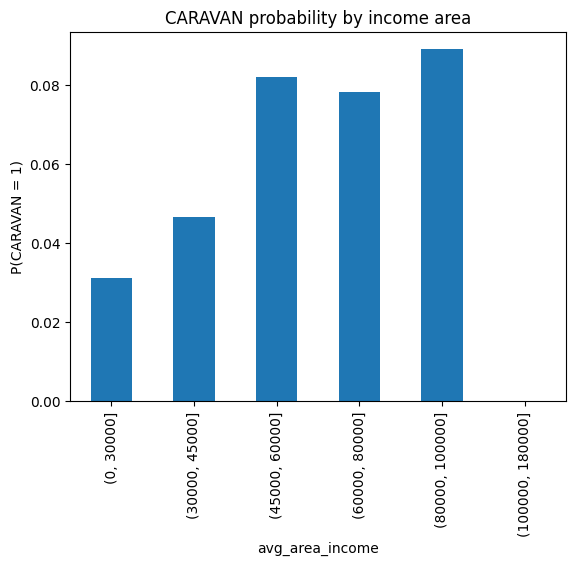

In [52]:
bins = [0, 30000, 45000, 60000, 80000, 100000, 180000]
df_income_bins = pd.DataFrame({
    'income_bin': pd.cut(X_train['avg_area_income'], bins=bins),
    'CARAVAN': y_train
})

rate_bin = df_income_bins.groupby('income_bin', observed=True)['CARAVAN'].mean()

ax = rate_bin.plot(kind='bar')
ax.set_xlabel("avg_area_income")
ax.set_ylabel("P(CARAVAN = 1)")
ax.set_title("CARAVAN probability by income area");

In [53]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()

features_significatifs = ["PPERSAUT", "PBRAND", "MBERARBG", "MGODPR", "MFALLEEN", "MGODGE"]

other_vars = ['avg_area_income']

X_train_sel = X_train[features_significatifs]
X_val_sel = X_val[features_significatifs]

print('|----- Avec tout les variables (VIF < 5) -----|')
model = feature_tracker.get_trained_model()
print()

print('|----- Seulement les variables significatives -----|')
model_var_signif_only = Model.create_model(X_train_sel.to_numpy(), y_train.to_numpy(), X_val_sel.to_numpy(), y_val.to_numpy(), learning_rate=0.01, threshold=0.1)
model_var_signif_only.print_val_stats()

|----- Avec tout les variables (VIF < 5) -----|
Threshold   : 0.1000
[[913 182]
 [ 33  37]]

|----- Seulement les variables significatives -----|
Threshold   : 0.1000
[[923 172]
 [ 39  31]]


### **PCA**

En regardant la projection PCA des observations FN et TP ne révèle pas de structure claire permettant de distinguer les deux groupes.

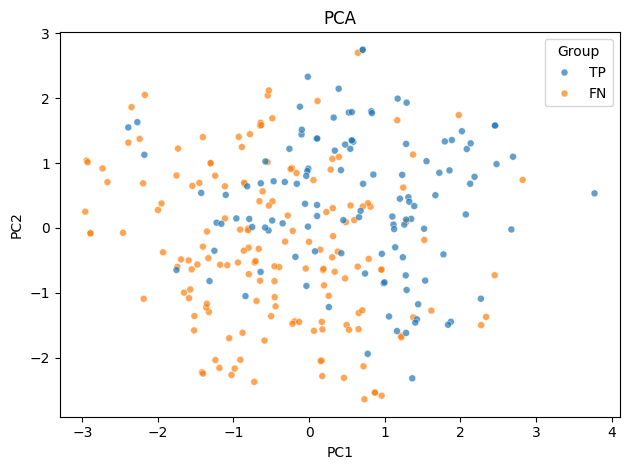

In [54]:
model = feature_tracker.get_trained_model(print_stats=False)
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=model.threshold, raw=True)
num_cols, cat_cols = feature_tracker.get_num_cat_cols()
df_loadings_pca_1 = plot_tools.plot_PCA(cat_cols, num_cols, df_profiles, TP_FN=True)

df_tp = df_profiles[df_profiles["Group"] == "TP"].copy()
df_fn = df_profiles[df_profiles["Group"] == "FN"].copy()

Mais, utiliser PCA dans mon cas peut etre une erreur.

PCA :

La matrice de covariance d'un échantillon : 

$$\mathbf{X} =  \begin{bmatrix}
\mathbf{x}_1 - \mathbf{\bar{x}}, \ldots, \mathbf{x}_n - \mathbf{\bar{x}}
\end{bmatrix}^\top
$$

$$\mathbf{S} = \frac{1}{n - 1} \mathbf{X}^\top \mathbf{X}$$

$$\mathbf{S} \propto \mathbf{X}^\top \mathbf{X} = \mathbf{W} \Lambda \mathbf{W}^\top$$

$\mathbf{W} = $ les eigenvectors de $\mathbf{S}$

$\Lambda = \mathrm{diag}(\lambda_1, \ldots, \lambda_k)$, les eigenvalues de $\mathbf{S}$  \
$\qquad$ $\lambda_k = \mathrm{Var}(\mathbf{X}\mathbf{w_k}) = \dfrac{1}{n-1} \sum_{i=1}^n(\mathbf{X}\mathbf{w_k})_i^2$ \
$\qquad$ aka les variances de la combinaison linéaire $k$ (ou la variance du score PCA de l'axe $k$).

Ce qui calcule la covariance de chaque variable avec chacune des autres.

Puisque $$\begin{aligned}
\mathbf{X}^\top \mathbf{X} &= \mathbf{W}\mathbf{\Sigma}^2\mathbf{W}^\top 
\end{aligned}$$

on a $$\mathbf{S} = \frac{1}{n-1} \mathbf{W}\mathbf{\Sigma}^2\mathbf{W}^\top \iff \mathbf{S} = \mathbf{W} \Lambda \mathbf{W}^\top$$

donc  $$\begin{aligned}
\mathbf{W} \Lambda \mathbf{W}^\top &= \frac{1}{n-1} \mathbf{W}\mathbf{\Sigma}^2\mathbf{W}^\top \\
\Lambda &= \frac{\mathbf{\Sigma}^2}{n-1}
\end{aligned}$$

$\dfrac{\mathbf{\Sigma}^2}{n-1} = \dfrac{1}{n-1}\mathrm{diag}(\sigma_1^2, \ldots, \sigma_k^2) = \Lambda$, les eigenvalues de $\mathbf{S}$.

$\qquad$ donc $\dfrac{\sigma_k^2}{n - 1} = \lambda_k \iff \sigma_k = \sqrt{(n-1)\lambda_k}$  

Ensuite, on décompose par valeur singulière pour obtenir les scores PCA.

$$\begin{aligned}
\mathbf{X} &= \mathbf{U\Sigma W}^\top \\
\mathbf{XW} &= (\mathbf{U\Sigma W}^\top) \mathbf{W} \\
\mathbf{XW} &= \mathbf{U\Sigma} 
\end{aligned}$$

$\mathbf{W}$ est les axes PCA (loadings), donc les axes PCA sont les eigenvectors de $\mathbf{S}$ \
$\mathbf{U}$ est les scores PCA normalisé. \
$\qquad$ Puisque $\mathbf{U} = \mathbf{XW\Sigma^{-1}}$ \
$\qquad$ et donc $\mathbf{u}_k = \dfrac{\mathbf{Xw_k}}{\sigma_k}$, où $\mathbf{Xw_k}$ est le score PCA de l'axe $k$.

Ensuite pour terminer, on choisit l'axe PCA $\mathbf{w}_k$ associer à la plus grande variance du score PCA $\lambda_k$, (donc $\text{PC}k =\mathbf{w}_k$)


Les scores PCA assume une relation linéaire entre les valeurs des variables ce qui peut causer des erreurs d'interprétations selon les axes PCA. 
$$(\alpha\mathbf{x}_a + \alpha\mathbf{x}_b)^\top \mathbf{w}_k \iff \alpha(\mathbf{x}_a^\top\mathbf{w}_k + \mathbf{x}_b^\top\mathbf{w}_k)$$

De plus, la PCA utilise une distance euclidienne, ce qui suppose que les écarts entre niveaux successifs d’une variable sont comparables. Cette hypothèse est problématique pour les variables ordinales.

Par exemple, mon top 3 de jeux vidéo est :
1. x
2. y
3. z

Mais j’aime **y** presque autant que **x**, j’aime tellement ces jeux que j’y rejoue à chaque année. Tandis que **z** est vraiment bon, oui, mais je ne l’aime pas assez pour **y** rejouer chaque année. Clairement, le passage de **z** à **y** est beaucoup plus "grand" que le passage de **y** à **x**.

Cela vaut également pour PPERSAUT, qui est aussi une variable ordinale. Rien ne garantit que l’effet de **PPERSAUT** sur la probabilité que **CARAVAN** = 1 évolue de manière linéaire avec ses niveaux.


Une des solutions pour régler ce problème est d’encoder les variables catégoriques en one-hot afin de forcer la PCA à attribuer un coefficient distinct à chaque modalité. Le problème avec cette solution est qu’elle entraîne une perte explicite de l’information d’ordinalité.

In [55]:
FeatureTools.get_df_conf_matrix_count_by_var("PPERSAUT", feature_tracker)

| PPERSAUT   |   FN count |   TP count |
|:-----------|-----------:|-----------:|
| 0.0        |         61 |          1 |
| 5.0        |          8 |          3 |
| 6.0        |         91 |        114 |
| Total      |        160 |        118 |

On peut observer cette conséquence de la PCA ci-dessous : 

Le premier graphique a été tracer avec deux variables continues:
1. $x_1 \in \{1, \ldots, 10\}$
2. $x_2 = 0.5 \cdot x_1 + \epsilon$

Le deuxième et troisième graphique ont été tracer avec deux variable ordinales, dont une similaires à celle de **PPERSAUT** pour les TP et FN ainsi que deux autres variables continues. La seule différence entre le troisième et deuxième graphique est que la variable ordinale à été one-hot encoded.
1. $x_1 \in \{0,5, 6\}$
2. $x_2 \in \{0,1,2,3,4\}$
2. $x_3 \in [0, 1]$
3. $x_4 = 0.8 \cdot x_2 + \epsilon$

J'ai essayer de simuler environ l'effet de PPERSAUT $= 6$ a sur les TP et FN. Une règle leur a été appliquer : 
- Si $x_1 = 6$ de l'observation $i$, alors $i$ a $60$% de chance de devenir un "TP", sinon est FN. 

Le premier graphique représente une projection PCA de variables continues. Elle est bien adapté ici.

Le deuxième est ce qui arrive lorsqu'on utilise des variables ordinale non one-hot encoded. Les points sont alignés selon leur niveaux ordinaux, car la PCA interprète ces niveaux comme des distances euclidiennes.

Le troisième graphique utilise les mêmes variables ordinales que le deuxième, mais one-hot encoded. La projection PCA ressemble alors à une distribution continue, mais l'information ordinale à été perdue. 

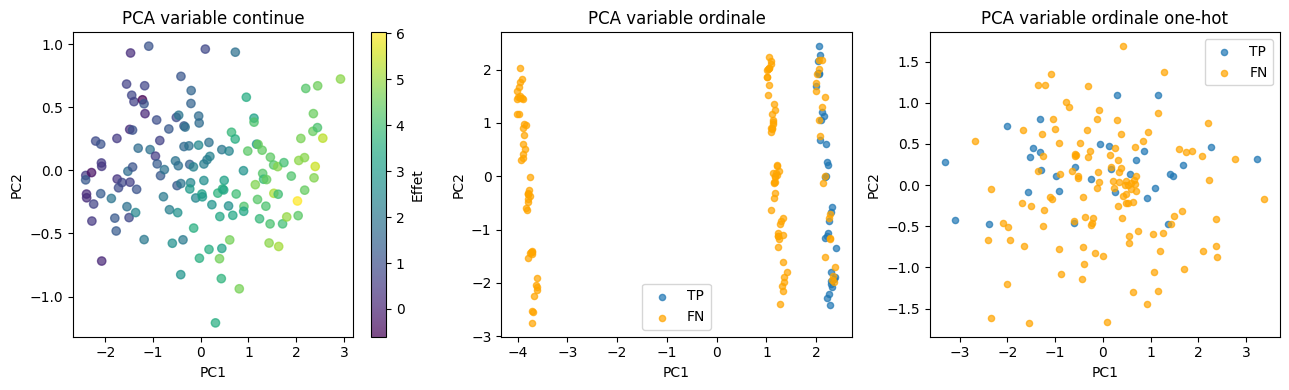

In [56]:
df_to_r_ex = ex.good_bad_PCA()

In [57]:
df_to_r_ex = data.prepare_catpca_df(df_to_r_ex, df_to_r_ex.columns, ["x_ord", "x_ord2"])

Maintenant, si l’on regarde la CATPCA, on peut observer qu’elle ne sépare pas les observations selon leurs valeurs ordinales, mais qu’elle révèle des sous-structures ordinales latentes. 

Dans cet exemple, certaines de ces structures présentent des régions où les TP et les FN ont des profils très similaires selon les variables.Si ce n'était pas un exemple, on aurait pu exploiter cette information afin d'analyser les FN proches des TP  et tenter d’augmenter le nombre de TP.

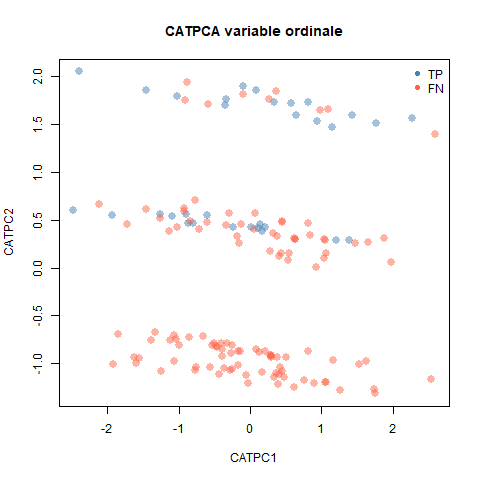

In [58]:
%%R -i df_to_r_ex
source("examples_files/graph_examples_extra.r")
ex_catpca(df_to_r_ex)

### **CATPCA**

Au lieu d'utiliser la PCA, je vais utiliser la CATPCA qui est beaucoup plus adapter pour les variables catégoriques ordinales.

In [59]:
X = feature_tracker.flush_to_df(removeTargets=True)
cols = X.columns
model = feature_tracker.get_trained_model(print_stats=False)
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=model.threshold, raw=True)
num_cols, cat_cols = feature_tracker.get_num_cat_cols()

In [60]:
df_profiles_with_constant = data.prepare_catpca_df(df_profiles, cols, cat_cols)
cols = df_profiles_with_constant.columns
col_group_idx = cols.get_loc('Group')
cols = cols.delete(col_group_idx)

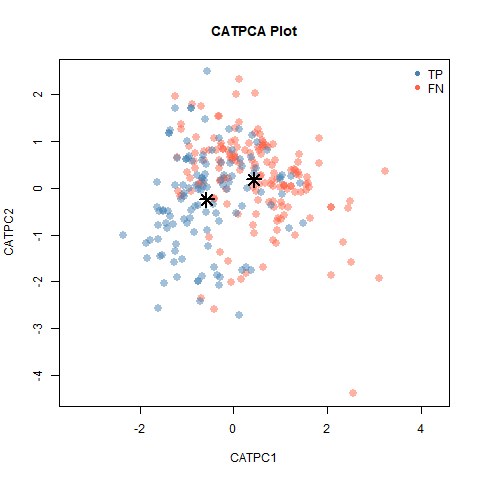

In [61]:
%%R -i df_profiles_with_constant -i num_cols -o df_loadings_catpca_1
source("plot_tools_extra.r")
out <- plot_catpca(df_profiles_with_constant, "TP", "FN", num_cols=num_cols)

df_loadings_catpca_1 <- as.data.frame(out$loadings)
colnames(df_loadings_catpca_1)[1:2] <- c("CATPC1", "CATPC2")

In [62]:
important_CATPC1 = df_loadings_catpca_1['CATPC1'].sort_values(ascending=False, key=abs).head(10)
important_CATPC1_with_desc = data.replace_by_name_desc(important_CATPC1)
important_CATPC1_with_desc

MHKOOP_Home_owners                  -0.736265
MKOOPKLA_Purchasing_power_class     -0.732033
MFALLEEN_Singles                     0.668722
avg_area_income                     -0.659695
MGEMOMV_Avg_size_household_1_to_6   -0.637760
MZPART_Private_health_insurance     -0.631583
MRELGE_Married                      -0.616093
MSKD_Social_class_D                  0.581210
MOPLHOOG_High_level_education       -0.536410
MBERHOOG_High_status                -0.535206
Name: CATPC1, dtype: float64

CATPC1 -> (-) vers les TP et (+) vers les FN

La première composante CATPCA (CATPC1) est principalement structurée par des variables socio-économiques. Les observations projetées vers la gauche de CATPC1 correspondent à des zones présentant des conditions socio-économiques plus favorables (propriétaires, pouvoir d’achat et revenu plus élevés), tandis que les observations projetées vers la droite sont associées à des contextes démographiques moins favorables, notamment une plus forte proportion de célibataires et de classe sociale moins favorable.

### TP vs FN

Je vais analyser de plus près les TP et FN.

In [63]:
X = feature_tracker.flush_to_df()
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
X_train_unscaled, *_ = feature_tracker.return_split_train_eval(to_scale=False)

model = feature_tracker.get_trained_model(print_stats=False)
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=0.1, raw=True)

df_tp = df_profiles[df_profiles["Group"] == "TP"].copy()
df_fn = df_profiles[df_profiles["Group"] == "FN"].copy()

La contribution d'un paramètre dans une regression logistique est $\beta_i x_i$. Alors pour comparer quel parametres distingue les TP vs FN. Je peux comparer les différences des contribution.

$$\Delta_i = \mathbb{E}(\beta_i x_i|TP) - \mathbb{E}(\beta_i x_i|FN)$$

Plus en plus la différence est grande, plus en plus un paramètre contribue à la décision de si c'est un TP ou FN.

In [64]:
contrib = df_profiles[X.drop('CARAVAN', axis=1).columns].mul(model.w, axis=1)
diff = contrib[df_profiles['Group'] == 'TP'].mean() - contrib[df_profiles['Group'] == 'FN'].mean()
diff.sort_values(key=abs, ascending=False).head()

PPERSAUT    0.413667
MGODGE      0.140490
MFALLEEN    0.136635
MBERARBG    0.121819
PBRAND      0.118089
dtype: float64

PPERSAUT est le paramètre principal qui décide si c'est un TP ou FN.

Je vais focus sur les FN count à PPERSAUT == 6, car la grande majorité des TP sont des PPERSAUT = 6. Je crois que sa serait plus facile de les changer à TP puisqu'ils ont la même valeur sur la variable dominante.

In [65]:
tab_tp = df_tp['PPERSAUT'].value_counts().rename('TP count')
tab_fn = df_fn['PPERSAUT'].value_counts().rename('FN count')
tab = pd.concat([tab_tp, tab_fn], axis=1).astype(int).rename_axis('PPERSAUT').reset_index()
total_row = pd.DataFrame([{
    'PPERSAUT': 'Total',
    'TP count': tab['TP count'].sum(),
    'FN count': tab['FN count'].sum()
}])

tab = pd.concat([tab, total_row], ignore_index=True)

Markdown(tab.to_markdown(index=False))

| PPERSAUT   |   TP count |   FN count |
|:-----------|-----------:|-----------:|
| 6.0        |        114 |         91 |
| 5.0        |          3 |          8 |
| 0.0        |          1 |         61 |
| Total      |        118 |        160 |

Maintenant si on focus sur les $(TP \cap PPERSAUT = 6)$ & $(FN \cap PPERSAUT = 6)$. 

Le paramètres principal est MFALLEEN (Singles). Qui est aussi, selon l'axe CATPC1, la variable qui a le plus d'influence sur si une observations se dirige vers la droite (donc vers les FN).

In [66]:
df_tp_ppersaut_6 = df_tp[df_tp['PPERSAUT'] == 6].copy()
df_fn_ppersaut_6 = df_fn[df_fn['PPERSAUT'] == 6].copy()
diff = contrib.loc[df_tp_ppersaut_6.index].mean() - contrib.loc[df_fn_ppersaut_6.index].mean()
diff.sort_values(key=abs, ascending=False).head()

MFALLEEN    0.194032
MGODGE      0.177950
MBERARBG    0.131553
MHKOOP      0.124223
PBRAND      0.112406
dtype: float64


|     (-) vers TP, (+) vers FN      |    CATPC1 |
|:----------------------------------|----------:|
| MFALLEEN_Singles                  |  0.668722 |

Les deux contributions sont négatives, donc MFALLEEN pénalise les deux, mais pénalise beaucoup plus les FN que les TP. Ce qui confirme que les FN ont en moyenne une concentration de célibataire plus élevé que les TP.

- Les TP avec PPERSAUT = 6 ont des valeurs MFALLEEN moins défavorable.
- Mais les FN avec PPERSAUT = 6 sont davantage pénalisés par MFALLEEN. 
- Il y a deux mode pour les MFALLEEN chez les FN, 0 et 3. 
    - Ceux avec une valeur de 0 ne sont pas pénalisé par MFALLEEN, mais ceux avec une valeur de 3, oui. 
    - Eux avec une valeur de 0 sont probablement pénalisés par d'autres variables.


In [67]:
tab = pd.DataFrame({
    'Group': ['TP (PPERSAUT = 6)', 'FN (PPERSAUT = 6)'],
    'Contribution moyenne (MFALLEEN)': [
        contrib.loc[df_tp_ppersaut_6.index, 'MFALLEEN'].mean(),
        contrib.loc[df_fn_ppersaut_6.index, 'MFALLEEN'].mean()
    ],
    'Mode (MFALLEEN)': [
        df_tp_ppersaut_6['MFALLEEN'].mode().tolist(),
        df_fn_ppersaut_6['MFALLEEN'].mode().tolist()
    ]})
Markdown(tab.to_markdown(index=False))

| Group             |   Contribution moyenne (MFALLEEN) | Mode (MFALLEEN)   |
|:------------------|----------------------------------:|:------------------|
| TP (PPERSAUT = 6) |                         -0.175075 | [0.0]             |
| FN (PPERSAUT = 6) |                         -0.369107 | [0.0, 3.0]        |

Presque tout les TP ont PPERSAUT = 6 et une partie importante des FN aussi. En créant une intéraction entre ces deux variables, l'effet de MFALLEEN dépend de la valeur de PPERSAUT. Donc avec cette variable, l'effet de MFALLEEN sera réduit ou annuler si PPERSAUT est élevé. 

$$\begin{aligned}
z &= w_1 ​x_1 ​+ w_2 ​x_2 ​+ w_3 ​(x_1​x_2​)+b \\
\frac{\partial z}{\partial x_1} &= w_1 + w_3x_2
\end{aligned}$$

Exemple : \
$x_2 = 6$ \
$w_1 = -0.4$ \
$w_3 = 0.1$ 

$$\frac{\partial z}{\partial x_1} = -0.4 + 0.1 \cdot  6 = 0.2$$

Mais créer l'intéraction PPERSAUTxMFALLEEN est une erreur, car PPERSAUTxMFALLEEN est hétérogène. 

PPERSAUTxMFALLEEN n'est pas ordinale car (PPERSAUT = 6)\*(MFALLEEN = 3) = (PPERSAUT = 3)\*(MFALLEEN = 6)

Mais dans mon cas, (PPERSAUT = 6)\*(MFALLEEN = 3) > (PPERSAUT = 3)\*(MFALLEEN = 6). 

Quelqu'un qui a un PPERSAUT = 6 est beaucoup plus significatif que quelqu'un qui a un MFALLEEN = 6.

In [68]:
print('Nombre de CARAVAN = 1 si :')
print('          (MFALLEEN = 6) : ', (X_train[y_train == 1]['MFALLEEN'] == 6).sum())
print('          (PPERSAUT = 6) : ', (X_train[y_train == 1]['PPERSAUT'] == 6).sum())

Nombre de CARAVAN = 1 si :
          (MFALLEEN = 6) :  4
          (PPERSAUT = 6) :  205


Le modèle va penser que (6,3) est aussi important que (3,6).

D'ailleurs, si je teste l'intéraction PPERSAUTxMFALLEEN je dois la standardiser, car sinon sa peut fausser mes résultats. Comme expliquer en haut, malgré que PPERSAUT et MFALLEEN soient ordinales. Le produit de ces deux variables ne l'est plus.

Ce qui peut arriver aussi est que le modèle va donner beaucoup trop d'attention a cette intéraction et ignorer les autres variables du a leur relativement petite variation.

In [69]:
feature_tracker.delete('PPERSAUTxMFALLEEN')
feature_tracker.add('PPERSAUTxMFALLEEN', X['PPERSAUT']*X['MFALLEEN'])
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[906 189]
 [ 30  40]]


Dans ce cas-ci, l'intéraction ne domine pas le modèle sans standardisation.

In [70]:
X_train, *_ = feature_tracker.return_split_train_eval()
coeff = pd.DataFrame({'w':model.w}, index=X.drop('CARAVAN', axis=1).columns)
max_val = X_train.max() 
(coeff['w']*max_val).sort_values(key=abs, ascending=False).head(10)

MFALLEEN            -1.717045
MGODGE              -1.671499
PPERSAUT             1.300767
MGODPR              -1.168208
MBERBOER            -1.052674
MSKD                -1.039890
MBERARBG            -0.953232
MRELSA              -0.843449
PPERSAUTxMFALLEEN    0.810052
MGEMLEEF            -0.781308
dtype: float64

Je crois quand même que standardiser PPERSAUTxMFALLEEN est mieux içi. La variable non-standardiser fonctionne bien seulement parce qu'il y a peu d'observation avec un MFALLEEN > PPERSAUT sur le set de validation. Donc peut-etre que sa fonctionne bien içi oui, mais peut-etre aussi que le set d'évaluation finale ne contient pas du tout la même structure de données. 

Si on regarde la matrice de confusion du training set sans standardisation, on peut voir qu'elle perd 2 TP, mais gagne 18 FN, malgré le gain de +3 TP sur le set de validation avec seulement +7 FN additionnel. Les valeur des données du set de validation favorise cette variable


La matrice de confusion avant l'ajout d'une des variables sur le training set est : $$\begin{bmatrix} 3670 & 708 \\ 160 & 118 \end{bmatrix}$$


| PPERSAUTxMFALLEEN        | Matrice de confusion (val set)                        | Matrice de confusion (train set)                         |
| ------------------------ | ----------------------------------------------------- | -------------------------------------------------------- |
| **Avec standardisation** | $$\begin{bmatrix} 909 & 186 \\ 33 & 37 \end{bmatrix}$$ | $$\begin{bmatrix} 3662 & 716 \\ 160 & 118 \end{bmatrix}$$|
| **Sans standardisation** | $$\begin{bmatrix} 906 & 189 \\ 30 & 40 \end{bmatrix}$$ | $$\begin{bmatrix} 3652 & 726 \\ 162 & 116 \end{bmatrix}$$|



La variable is_PPERSAUT_6xMFALLEEN est la plus efficace. En plus, elle donne des résultats identique a PPERSAUTxMFALLEEN non-standardiser. Elle vise les clients avec un PPERSAUT = 6, qui représente la quasi-totalité des TP et plus que le moitié des FN.

In [71]:
feature_tracker.delete('PPERSAUTxMFALLEEN')
X = feature_tracker.flush_to_df()

feature_tracker.add('PPERSAUTxMFALLEEN', X['PPERSAUT']*X['MFALLEEN'], toScale=True)
feature_tracker.add('PPERSAUT_DOM_MFALLEEN', (X['PPERSAUT'] > X['MFALLEEN']).astype(int))
feature_tracker.add('is_PPERSAUT_6xMFALLEEN', ((X['PPERSAUT'] == 6) * (X['MFALLEEN'])).astype(int))
feature_tracker.add('is_PPERSAUT_6xMFALLEEN_geq_3', (((X['PPERSAUT'] == 6) & (X['MFALLEEN'] >= 3)) * X['MFALLEEN']).astype(int))
vars_to_test = ['PPERSAUTxMFALLEEN', 'PPERSAUT_DOM_MFALLEEN', 'is_PPERSAUT_6xMFALLEEN', 'is_PPERSAUT_6xMFALLEEN_geq_3']

feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, threshold=0.1, print_metrics=False)

|----- Variable de base -----|
Threshold   : 0.1000
[[913 182]
 [ 33  37]]

|----- PPERSAUTxMFALLEEN -----|
Threshold   : 0.1000
[[909 186]
 [ 33  37]]

|----- PPERSAUT_DOM_MFALLEEN -----|
Threshold   : 0.1000
[[915 180]
 [ 33  37]]

|----- is_PPERSAUT_6xMFALLEEN -----|
Threshold   : 0.1000
[[906 189]
 [ 30  40]]

|----- is_PPERSAUT_6xMFALLEEN_geq_3 -----|
Threshold   : 0.1000
[[909 186]
 [ 31  39]]



En plus, elle ne souffre pas du même défaut que PPERSAUTxMFALLEEN non-standardiser. 

La variable non-standardiser -> -2 TP, +18 FN \
is_PPERSAUT_6xMFALLEEN -> +2 TP, +21 FN

In [72]:
feature_tracker.delete('PPERSAUTxMFALLEEN')
feature_tracker.add('PPERSAUTxMFALLEEN', X['PPERSAUT']*X['MFALLEEN'], toScale=False)
vars_to_test = ['PPERSAUTxMFALLEEN', 'is_PPERSAUT_6xMFALLEEN', 'is_PPERSAUT_6xMFALLEEN_geq_3']
X = feature_tracker.flush_to_df()

feature_tracker.restore_list(vars_to_test)

feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, threshold=0.1, print_metrics=False, test_on_train=True)

|----- Variable de base -----|
Threshold   : 0.1000
[[3670  708]
 [ 160  118]]

|----- PPERSAUTxMFALLEEN -----|
Threshold   : 0.1000
[[3652  726]
 [ 162  116]]

|----- is_PPERSAUT_6xMFALLEEN -----|
Threshold   : 0.1000
[[3649  729]
 [ 158  120]]

|----- is_PPERSAUT_6xMFALLEEN_geq_3 -----|
Threshold   : 0.1000
[[3651  727]
 [ 163  115]]



In [73]:
feature_tracker.restore('is_PPERSAUT_6xMFALLEEN')
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[906 189]
 [ 30  40]]


In [74]:
X_train, y_train, *_ = feature_tracker.return_split_train_eval()
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=0.1, raw=True)
contrib = FeatureTools.get_df_conf_matrix_contrib(feature_tracker, model)
diff = contrib[df_profiles['Group'] == 'TP'].mean() - contrib[df_profiles['Group'] == 'FN'].mean()
diff.sort_values(key=abs, ascending=False).head()

PPERSAUT    0.378984
MGODGE      0.139305
MBERARBG    0.124399
PBRAND      0.123497
MFALLEEN    0.104887
dtype: float64

MGODGE est le prochain paramètre principale.

In [75]:
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

df_tp_ppersaut_6 = df_tp[df_tp['PPERSAUT'] == 6].copy()
df_fn_ppersaut_6 = df_fn[df_fn['PPERSAUT'] == 6].copy()

diff = contrib.loc[df_tp_ppersaut_6.index].mean() - contrib.loc[df_fn_ppersaut_6.index].mean()
diff.sort_values(key=abs, ascending=False).head()

MGODGE      0.174892
MFALLEEN    0.146075
MBERARBG    0.139681
MHKOOP      0.128525
PBRAND      0.123965
dtype: float64

Pareil, içi que MFALLEEN. Les deux contributions sont négatives, donc MGODGE pénalise les deux, mais pénalise beaucoup plus les FN que les TP.

In [76]:
tab = FeatureTools.get_df_conf_matrix_contrib_analysis('PPERSAUT', 6, 'MGODGE', feature_tracker, model)
Markdown(tab.to_markdown(index=False)) 

| Group             |   Contribution moyenne (MGODGE) | Mode (MGODGE)   |
|:------------------|--------------------------------:|:----------------|
| TP (PPERSAUT = 6) |                       -0.486    | [3.0]           |
| FN (PPERSAUT = 6) |                       -0.660893 | [5.0]           |

In [77]:
pd.crosstab(df_fn['PPERSAUT'], df_fn['MGODGE'])

MGODGE,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
PPERSAUT,,,,,,,,
0.0,5,4,11,22,12,4,0,3
5.0,0,0,1,3,4,1,0,0
6.0,5,4,13,16,20,25,4,1


Sur le set de validation, la meilleure variable apporte seulement un gain de précision (-4 FP)

In [78]:
X = feature_tracker.flush_to_df()
feature_tracker.add('PPERSAUT_DOM_MGODGE', (X['PPERSAUT'] > X['MGODGE']).astype(int))
feature_tracker.add('is_high_no_religion_area', (X['MGODGE'] >= 4).astype(int))
feature_tracker.add('is_low_no_religion_area', (X['MGODGE'] <= 3).astype(int))

X = feature_tracker.flush_to_df()

feature_tracker.add('PPERSAUTxis_high_no_religion_area', X['PPERSAUT']*X['is_high_no_religion_area'])
feature_tracker.add('PPERSAUTxis_low_no_religion_area', X['PPERSAUT']*X['is_low_no_religion_area'])
vars_to_test = ['PPERSAUT_DOM_MGODGE', 'is_high_no_religion_area', 'is_low_no_religion_area', 'PPERSAUTxis_high_no_religion_area', 'PPERSAUTxis_low_no_religion_area']
feature_tracker.remove_list(vars_to_test)
X = feature_tracker.flush_to_df()

feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, threshold=0.1, print_metrics=False)

|----- Variable de base -----|
Threshold   : 0.1000
[[906 189]
 [ 30  40]]

|----- PPERSAUT_DOM_MGODGE -----|
Threshold   : 0.1000
[[905 190]
 [ 30  40]]

|----- is_high_no_religion_area -----|
Threshold   : 0.1000
[[907 188]
 [ 30  40]]

|----- is_low_no_religion_area -----|
Threshold   : 0.1000
[[908 187]
 [ 30  40]]

|----- PPERSAUTxis_high_no_religion_area -----|
Threshold   : 0.1000
[[907 188]
 [ 30  40]]

|----- PPERSAUTxis_low_no_religion_area -----|
Threshold   : 0.1000
[[910 185]
 [ 30  40]]



Mais sur le training set, elle apporte un gain de +1 TP et -12 FN. Je vais garder la variable puisqu'elle semble avoir aucun effet négatif. 

In [79]:
vars_to_test = ['is_low_no_religion_area', 'PPERSAUTxis_low_no_religion_area']
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, test_on_train=True, threshold=0.1, print_metrics=False)


|----- Variable de base -----|
Threshold   : 0.1000
[[3649  729]
 [ 158  120]]

|----- is_low_no_religion_area -----|
Threshold   : 0.1000
[[3648  730]
 [ 160  118]]

|----- PPERSAUTxis_low_no_religion_area -----|
Threshold   : 0.1000
[[3661  717]
 [ 157  121]]



In [80]:
feature_tracker.restore('PPERSAUTxis_low_no_religion_area')
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[910 185]
 [ 30  40]]


Maintenant, si on regarde les TP vs FN encore :

In [81]:
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

df_tp_ppersaut_6 = df_tp[df_tp['PPERSAUT'] == 6].copy()
df_fn_ppersaut_6 = df_fn[df_fn['PPERSAUT'] == 6].copy()

contrib_tp = contrib.loc[df_tp_ppersaut_6.index].mean()
contrib_tp.sort_values(key=abs, ascending=False).head(10)

PPERSAUT    0.985759
MGODPR     -0.649561
MGODGE     -0.488160
MAUT1      -0.446813
MGEMLEEF   -0.380198
MRELGE     -0.342093
MHKOOP      0.288796
PBRAND      0.288420
MFALLEEN   -0.230734
MFWEKIND   -0.225460
dtype: float64

Ce qui distingue majoritairement les TP vs FN est 
- PPERSAUT (Contribution car policies)
    - TP : Presque uniquement 6
    - FN : Majoritairement 6 mais aussi 0 (encore)
- PBRAND (Contribution fire policie)
    - TP : Surtout 4
    - FN : Surtout 0, mais aussi 4
- MFALLEEN 
    - TP : Surtout 0, mais aussi 1-2
    - FN : Majoritairement 0

In [82]:
vars = contrib_tp.sort_values(key=abs, ascending=False).head(10).index
FeatureTools.get_df_dom(vars, feature_tracker, thresh=0.2)

|    | Variable   | TP valeurs dominantes   | TP (count)                       | FN valeurs dominantes   | FN (count)                       |
|---:|:-----------|:------------------------|:---------------------------------|:------------------------|:---------------------------------|
|  0 | PPERSAUT   | 6                       | 118 / 121                        | 0<br>6                  | 61 / 157<br>87 / 157             |
|  1 | MGODPR     | 4<br>5                  | 27 / 121<br>37 / 121             | 4<br>5                  | 43 / 157<br>42 / 157             |
|  2 | MGODGE     | 2<br>3                  | 27 / 121<br>32 / 121             | 3<br>4                  | 40 / 157<br>37 / 157             |
|  3 | MAUT1      | 6<br>7                  | 26 / 121<br>44 / 121             | 6<br>7                  | 47 / 157<br>50 / 157             |
|  4 | MGEMLEEF   | 2<br>3                  | 32 / 121<br>63 / 121             | 2<br>3                  | 38 / 157<br>82 / 157             |
|  5 | MRELGE     | 7<br>9                  | 41 / 121<br>31 / 121             | 6<br>7                  | 34 / 157<br>52 / 157             |
|  6 | MHKOOP     | 9                       | 48 / 121                         | -                       | -                                |
|  7 | PBRAND     | 4                       | 77 / 121                         | 0<br>3<br>4             | 72 / 157<br>38 / 157<br>38 / 157 |
|  8 | MFALLEEN   | 0<br>1<br>2             | 48 / 121<br>25 / 121<br>32 / 121 | 0                       | 49 / 157                         |
|  9 | MFWEKIND   | 4                       | 27 / 121                         | -                       | -                                |

Puisque je sais que PBRAND et PPERSAUT sont des variables significatives, je crois que créer une interaction entre ces termes pourrait être bénéfique. 

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 28 | PPERSAUT  |      0.1626 | 1.1203 |      1.1456 |      1.2633 |
| 40 | PBRAND    |      0.0905 | 1.0969 |      1.0076 |      1.194  |

Dans les FN, si on regarde $(FN \cap PBRAND > 0)$, on peut voir qu'il y a 55 potentiels TP dans le training set qui ont PPERSAUT > 0.

In [83]:
df_sub = df_fn[(df_fn["PBRAND"] > 0) & (df_fn["PPERSAUT"] > 0)]
pd.crosstab(df_sub["PPERSAUT"], df_sub["PBRAND"], margins=True)

PBRAND,1.0,2.0,3.0,4.0,5.0,6.0,All
PPERSAUT,,,,,,,
5.0,1,0,3,4,0,0,8
6.0,1,4,23,17,1,1,47
All,2,4,26,21,1,1,55


Puisque la majorité des FN avec un PBRAND > 0 se situe sur 3 et 4. Je vais viser ce groupe.

In [84]:
pd.crosstab(df_tp['PPERSAUT'], df_tp['PBRAND'], margins=True)

PBRAND,0.0,1.0,2.0,3.0,4.0,5.0,All
PPERSAUT,,,,,,,
0.0,0,0,0,0,1,0,1
5.0,0,0,0,0,2,0,2
6.0,19,1,1,17,74,6,118
All,19,1,1,17,77,6,121


J'ai tester deux variables : PPERSAUTxPBRAND_geq_3 et PPERSAUTx_is_PBRAND_3_4.
- PPERSAUTxPBRAND_geq_3 -> +3 TP, +5 FN
- PPERSAUTx_is_PBRAND_3_4 -> +1 TP, +3 FN

In [85]:
X = feature_tracker.flush_to_df()
feature_tracker.add('PPERSAUTxPBRAND_geq_3',((X["PPERSAUT"])*(X['PBRAND'] >= 3)))
feature_tracker.add('PPERSAUTx_is_PBRAND_3_4',((X["PPERSAUT"])*(X['PBRAND'].isin([3,4]))))

vars_to_test = ['PPERSAUTxPBRAND_geq_3', 'PPERSAUTx_is_PBRAND_3_4']
feature_tracker.remove_list(vars_to_test)

X = feature_tracker.flush_to_df()
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, print_metrics=False, threshold=0.1)

|----- Variable de base -----|
Threshold   : 0.1000
[[910 185]
 [ 30  40]]

|----- PPERSAUTxPBRAND_geq_3 -----|
Threshold   : 0.1000
[[905 190]
 [ 27  43]]

|----- PPERSAUTx_is_PBRAND_3_4 -----|
Threshold   : 0.1000
[[907 188]
 [ 29  41]]



In [86]:
print('|----- Avant les variables (training set) -----|')
feature_tracker.remove('PPERSAUTxPBRAND_geq_3')
feature_tracker.remove('PPERSAUTx_is_PBRAND_3_4')
FeatureTools.get_df_conf_matrix_count_by_var('PPERSAUT', feature_tracker)

|----- Avant les variables (training set) -----|


| PPERSAUT   |   FN count |   TP count |
|:-----------|-----------:|-----------:|
| 0.0        |         61 |          1 |
| 5.0        |          9 |          2 |
| 6.0        |         87 |        118 |
| Total      |        157 |        121 |

Dans le set de training
- PPERSAUTxPBRAND_geq_3 -> +17, -3 FN
- PPERSAUTx_is_PBRAND_3_4 -> +16 TP, -18 FN
    - un des TP est PPERSAUT = 5

In [87]:
vars_to_test = ['PPERSAUTxPBRAND_geq_3', 'PPERSAUTx_is_PBRAND_3_4']
X = feature_tracker.flush_to_df()
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, test_on_train=True, threshold=0.1, print_metrics=False)

|----- Variable de base -----|
Threshold   : 0.1000
[[3661  717]
 [ 157  121]]

|----- PPERSAUTxPBRAND_geq_3 -----|
Threshold   : 0.1000
[[3664  714]
 [ 140  138]]

|----- PPERSAUTx_is_PBRAND_3_4 -----|
Threshold   : 0.1000
[[3679  699]
 [ 141  137]]



Je vais garder **PPERSAUTx_is_PBRAND_3_4**, malgré le +1 TP de plus de **PPERSAUTxPBRAND_geq_3**, car la majorité des **CARAVAN** $= 1$ se situe à **PBRAND_Contribution_fire_policies** $\in \{3,4\}$, seulement $8$ acheteurs d'assurance caravan ont cette attribue plus haut $4$, c'est trop spécifique.

In [88]:
pd.crosstab(X_train["PBRAND"], y_train)

CARAVAN,0,1
PBRAND,,
0,2063,91
1,126,3
2,411,6
3,668,55
4,860,115
5,119,7
6,124,1
7,6,0
8,1,0


In [89]:
feature_tracker.restore('PPERSAUTx_is_PBRAND_3_4')
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[907 188]
 [ 29  41]]


In [90]:
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

In [91]:
df_profiles_with_constant = data.prepare_catpca_df(df_profiles, cols, cat_cols)
cols = df_profiles_with_constant.columns
col_group_idx = cols.get_loc('Group')
cols = cols.delete(col_group_idx)

### LDA

Cette fois ci, je vais tester la LDA. Elle permet de séparer les différentes classes en sous-groupe en trouvant des axes qui maximisent la séparation entre groupes.

$X = (x_1,x_2, \ldots x_n) = $ les variables (ou features) \
$Y \in \{0, 1\}$, où 0 et 1 sont les classes (TP et FN par exemple)

Un axe LDA est défini par $$LDA = w^\top X = w_1x_1 + w_2x_2 + \ldots + w_nx_n$$

$$S = \frac{\sigma^2_{\text{inter}}}{\sigma^2_{\text{intra}}} = \frac{(w^\top (\mu_1 - \mu_0))^2}{w^\top (\Sigma_0 + \Sigma_1) w} = w \propto (\Sigma_0 + \Sigma_1)^{-1}(\mu_1 - \mu_0)$$

Les somme $\Sigma_0$ et $\Sigma_1$ sont les matrices de covariance de la classe 0 et 1

$$\Sigma_k = \mathrm{Cov}(X| Y = k) = \frac{1}{n_k-1}(X_k-\mu_k)^\top(X_k-\mu_k) =
\begin{bmatrix}
\mathrm{Var}(x_1) & \mathrm{Cov}(x_1,x_2) & \cdots \\
\mathrm{Cov}(x_2,x_1) & \mathrm{Var}(x_2) & \cdots \\
\vdots & & \ddots
\end{bmatrix}$$

où : $$\mathrm{Cov}(x_i,x_j) = \mathbb{E}\big[(x_i​−\mu_{k,i}​)(x_j​−\mu_{k,j}) | Y = k\big]$$

Exemple : \
$x_1 = PPERSAUT$ \
$x_2 = PBRAND$

$Y = 0:FN$ \
$Y = 1:TP$ 

$X_0 =
\begin{bmatrix}
2 & 1 \\
3 & 2 \\
4 & 2
\end{bmatrix}, \quad \mu_0 = \begin{bmatrix}
3, \frac{5}{3}
\end{bmatrix}$

$X_1 =
\begin{bmatrix}
5 & 5 \\
6 & 5 \\
7 & 6
\end{bmatrix}, \quad \mu_1 = \begin{bmatrix}
6, \frac{17}{3}
\end{bmatrix}$

$n_0 = n_1 = 3$

$$\mu_1 - \mu_0 = \begin{bmatrix}
6 - 3, \frac{17}{3} - \frac{5}{3}
\end{bmatrix} = \begin{bmatrix}
3, 4
\end{bmatrix}$$

$$X_0 - J_{3,1}\mu_0 = 
\begin{bmatrix}
2-3 & 1-\tfrac{5}{3} \\
3-3 & 2-\tfrac{5}{3} \\
4-3 & 2-\tfrac{5}{3}
\end{bmatrix} = \begin{bmatrix}
-1 & -\tfrac{2}{3} \\
0 & \tfrac{1}{3} \\
1 & \tfrac{1}{3}
\end{bmatrix}
$$

$$
X_1 - J_{3,1}\mu_1 = \begin{bmatrix}
5-6 & 5-\tfrac{17}{3} \\
6-6 & 5-\tfrac{17}{3} \\
7-6 & 6-\tfrac{17}{3}
\end{bmatrix} = \begin{bmatrix}
-1 & -\tfrac{2}{3} \\
0 & -\tfrac{2}{3} \\
1 & \tfrac{1}{3} \\
\end{bmatrix} 
$$

$$
\Sigma_0 = \frac{1}{n_0}(X_0 - \mu_0)^\top(X_0 - \mu_0) = \frac{1}{3}\begin{bmatrix}
2 & 1 \\
1 & \tfrac{2}{3}
\end{bmatrix} = \begin{bmatrix}
\tfrac{2}{3} & \tfrac{1}{3} \\
\tfrac{1}{3} & \tfrac{2}{9}
\end{bmatrix} 
$$

$$
\Sigma_1 = \frac{1}{n_1}(X_1 - \mu_1)^\top(X_1 - \mu_1) = 
\frac{1}{3}\begin{bmatrix}
2 & 1 \\
1 & 1
\end{bmatrix} = \begin{bmatrix}
\tfrac{2}{3} & \tfrac{1}{3} \\
\tfrac{1}{3} & \tfrac{1}{3} \\
\end{bmatrix}
$$

$$\Sigma_0 + \Sigma_1 = \begin{bmatrix}
\tfrac{4}{3} & \tfrac{2}{3} \\
\tfrac{2}{3} & \tfrac{5}{9} \\
\end{bmatrix}$$

$$(\Sigma_0 + \Sigma_1)^{-1} = 
\begin{bmatrix}
\tfrac{18}{8} & \tfrac{-9}{4} \\
\tfrac{-9}{4} & \tfrac{9}{2} \\
\end{bmatrix}$$

$$w \propto (\Sigma_0 + \Sigma_1)^{-1}(\mu_1 - \mu_0) = \begin{bmatrix}
\tfrac{18}{8} & \tfrac{-9}{4} \\
\tfrac{-9}{4} & \tfrac{9}{2} 
\end{bmatrix} \begin{bmatrix}
3 \\
4
\end{bmatrix} = \begin{bmatrix}
\tfrac{-27}{8} \\
\tfrac{45}{4}
\end{bmatrix}$$

Et puisque $w$ est un eigenvector 

$$w \propto \begin{bmatrix}
-1 \\
4
\end{bmatrix}$$ 

Donc 
$$ LDA = (-1) \cdot PPERSAUT + 4 \cdot PBRAND $$

Ce qui veut dire que la variable PBRAND augmente fortement le score LDA et pousse vers la classe 1 (TP dans notre cas) plus en plus qu'elle est élevé. Tandis qu'une valeur élevée de PPERSAUT diminue le score LDA et pousse vers la classe 0 (FN dans notre cas)


Mais le même problème que pour la PCA se présente ici. La LDA suppose également que les relations entre les variables sont linéaires :
$$\mathrm{LDA} = w^\top X.$$
Elle utilise donc une distance euclidienne, ce qui implique que les distances entre les valeurs des variables sont considérées comme équivalentes. Mais encore, rien ne garantit que l’importance des valeurs de certaines variables augmente ou diminue de façon linéaire, comme démontré précédemment avec l'exemple de PCA.


Si on observe les données de la LDA, on voit qu'elle tombe dans le meme piege que PCA. Elle repete simplement l'information contenu dans les variables.

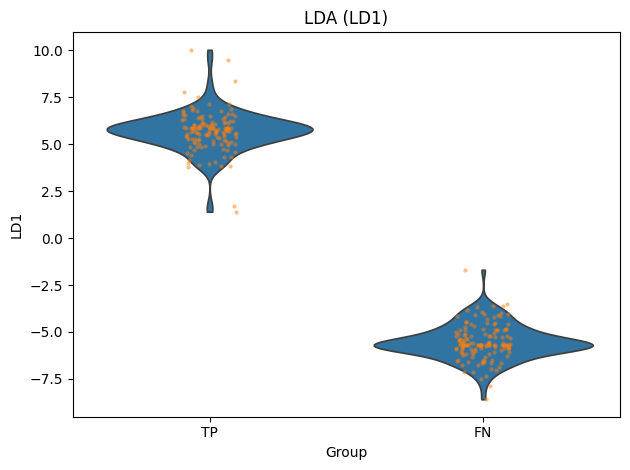

In [92]:
X = feature_tracker.flush_to_df(removeTargets=True)
model = feature_tracker.get_trained_model(print_stats=False)
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=model.threshold, raw=True)

num_cols, cat_cols = feature_tracker.get_num_cat_cols()

loadings = plot_tools.plot_LDA(cat_cols, num_cols, df_profiles, TP_FN=True)

In [93]:
loadings.head()

,LD1
MOSTYPE_41,193.118790
MRELSA_4,140.859319
PBRAND_6,-133.704017
MAUT2_5,-129.444601
PPLEZIER_1,94.087151


In [94]:
model = feature_tracker.get_trained_model()
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

Threshold   : 0.1000
[[907 188]
 [ 29  41]]


Je vais essayer de créer des interactions avec les variables qui contribuent le plus à l’axe CATPC1 vers la gauche afin d’essayer de faire basculer des FN vers des TP.

In [95]:
important_CATPC1_with_desc

MHKOOP_Home_owners                  -0.736265
MKOOPKLA_Purchasing_power_class     -0.732033
MFALLEEN_Singles                     0.668722
avg_area_income                     -0.659695
MGEMOMV_Avg_size_household_1_to_6   -0.637760
MZPART_Private_health_insurance     -0.631583
MRELGE_Married                      -0.616093
MSKD_Social_class_D                  0.581210
MOPLHOOG_High_level_education       -0.536410
MBERHOOG_High_status                -0.535206
Name: CATPC1, dtype: float64

In [96]:
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

In [97]:
pd.crosstab(df_tp['PPERSAUT'], df_tp['MHKOOP'], margins=True)

MHKOOP,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
PPERSAUT,,,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,1,0,1
5.0,0,0,0,2,1,0,0,2,0,0,5
6.0,7,5,10,6,10,10,9,13,13,48,131
All,7,5,10,8,11,10,9,15,14,48,137


In [98]:
pd.crosstab(df_fn['PPERSAUT'], df_fn['MHKOOP'], margins=True)

MHKOOP,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
PPERSAUT,,,,,,,,,,,
0.0,6,1,3,4,5,2,8,10,7,15,61
5.0,0,1,0,0,0,1,1,0,3,0,6
6.0,11,8,5,4,7,4,11,7,7,10,74
All,17,10,8,8,12,7,20,17,17,25,141


**PPERSAUTxMHKOOP_geq_6** apporte un gain de +2 TP et -7 FP \
**PPERSAUTxMHKOOP_geq_4** apporte un gain de +1 TP et -3 FP


In [99]:
X = feature_tracker.flush_to_df()
feature_tracker.add('PPERSAUTxMHKOOP_geq_4',((X["PPERSAUT"])*(X['MHKOOP'] >= 4)))
feature_tracker.add('PPERSAUTxMHKOOP_geq_6',((X["PPERSAUT"])*(X['MHKOOP'] >= 6)))
feature_tracker.add('PPERSAUT_6xMHKOOP', ((X["PPERSAUT"] == 6)*(X['MHKOOP'])))

vars_to_test = ['PPERSAUTxMHKOOP_geq_4', 'PPERSAUTxMHKOOP_geq_6', 'PPERSAUT_6xMHKOOP']
feature_tracker.remove_list(vars_to_test)

X = feature_tracker.flush_to_df()
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, print_metrics=False, threshold=0.1)

|----- Variable de base -----|
Threshold   : 0.1000
[[907 188]
 [ 29  41]]

|----- PPERSAUTxMHKOOP_geq_4 -----|
Threshold   : 0.1000
[[910 185]
 [ 28  42]]

|----- PPERSAUTxMHKOOP_geq_6 -----|
Threshold   : 0.1000
[[914 181]
 [ 27  43]]

|----- PPERSAUT_6xMHKOOP -----|
Threshold   : 0.1000
[[915 180]
 [ 30  40]]



Mais sur le training set : 
- **PPERSAUTxMHKOOP_geq_4** -> -3 TP, -12 FP
- **PPERSAUTxMHKOOP_geq_6** -> -10 FP

In [100]:
vars_to_test = ['PPERSAUTxMHKOOP_geq_4', 'PPERSAUTxMHKOOP_geq_6']
feature_tracker.remove_list(vars_to_test)

X = feature_tracker.flush_to_df()
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, print_metrics=False, threshold=0.1, test_on_train=True)

|----- Variable de base -----|
Threshold   : 0.1000
[[3679  699]
 [ 141  137]]

|----- PPERSAUTxMHKOOP_geq_4 -----|
Threshold   : 0.1000
[[3691  687]
 [ 144  134]]

|----- PPERSAUTxMHKOOP_geq_6 -----|
Threshold   : 0.1000
[[3689  689]
 [ 141  137]]



Je vais garder **PPERSAUTxMHKOOP_geq_6**, elle ne semble présenter aucun aspect négatif.


In [101]:
feature_tracker.restore('PPERSAUTxMHKOOP_geq_6')
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[914 181]
 [ 27  43]]


In [102]:
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

La prochaine variable discriminante selon CATPC1 est **MKOOPKLA_Purchasing_power_class**

In [103]:
important_CATPC1_with_desc

MHKOOP_Home_owners                  -0.736265
MKOOPKLA_Purchasing_power_class     -0.732033
MFALLEEN_Singles                     0.668722
avg_area_income                     -0.659695
MGEMOMV_Avg_size_household_1_to_6   -0.637760
MZPART_Private_health_insurance     -0.631583
MRELGE_Married                      -0.616093
MSKD_Social_class_D                  0.581210
MOPLHOOG_High_level_education       -0.536410
MBERHOOG_High_status                -0.535206
Name: CATPC1, dtype: float64

In [104]:
pd.crosstab(df_tp['PPERSAUT'], df_tp['MKOOPKLA'], margins=True)

MKOOPKLA,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,All
PPERSAUT,,,,,,,,,
0.0,0,0,0,0,0,1,0,0,1
5.0,0,0,0,0,3,1,1,0,5
6.0,3,5,24,12,7,26,31,23,131
All,3,5,24,12,10,28,32,23,137


In [105]:
pd.crosstab(df_fn['PPERSAUT'], df_fn['MKOOPKLA'], margins=True)

MKOOPKLA,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,All
PPERSAUT,,,,,,,,,
0.0,7,0,11,10,7,9,14,3,61
5.0,1,0,2,3,0,0,0,0,6
6.0,6,6,24,13,7,10,4,4,74
All,14,6,37,26,14,19,18,7,141


La variable **PPERSAUT_6xMKOOPKLA** apporte un gain de +1 TP et -7 FP

In [106]:
X = feature_tracker.flush_to_df()
feature_tracker.add('PPERSAUTxMKOOPKLA_geq_3',((X["PPERSAUT"])*(X['MKOOPKLA'] >= 3)))
feature_tracker.add('PPERSAUT_6xMKOOPKLA', ((X["PPERSAUT"] == 6)*(X['MKOOPKLA'])))

vars_to_test = ['PPERSAUTxMKOOPKLA_geq_3', 'PPERSAUT_6xMKOOPKLA']
feature_tracker.remove_list(vars_to_test)

X = feature_tracker.flush_to_df()
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, print_metrics=False, threshold=0.1)

|----- Variable de base -----|
Threshold   : 0.1000
[[914 181]
 [ 27  43]]

|----- PPERSAUTxMKOOPKLA_geq_3 -----|
Threshold   : 0.1000
[[914 181]
 [ 28  42]]

|----- PPERSAUT_6xMKOOPKLA -----|
Threshold   : 0.1000
[[921 174]
 [ 26  44]]



En revanche, sur le training set, elle apporte plutôt un gain massif de précision uniquement, avec **−32 FP**!!

In [107]:
vars_to_test = ['PPERSAUT_6xMKOOPKLA']
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, print_metrics=False, test_on_train=True, threshold=0.1)

|----- Variable de base -----|
Threshold   : 0.1000
[[3689  689]
 [ 141  137]]

|----- PPERSAUT_6xMKOOPKLA -----|
Threshold   : 0.1000
[[3721  657]
 [ 141  137]]



In [108]:
feature_tracker.restore('PPERSAUT_6xMKOOPKLA')
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[921 174]
 [ 26  44]]


In [109]:
corr = FeatureTools.find_correlated_cols(X_train, toPlot=False)
corr

[]

In [110]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=model.threshold, raw=True)
cols = X_train.columns
num_cols, cat_cols = feature_tracker.get_num_cat_cols()

df_profiles_with_constant = data.prepare_catpca_df(df_profiles, cols, cat_cols)
cols = df_profiles_with_constant.columns
col_group_idx = cols.get_loc('Group')
cols = cols.delete(col_group_idx)

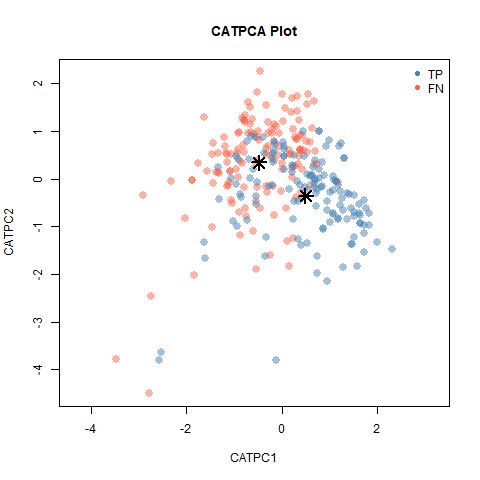

In [111]:
%%R -i df_profiles_with_constant -i num_cols -o df_loadings_catpca_2 -o df_scores_catpca_2
source("plot_tools_extra.r")
out <- plot_catpca(df_profiles_with_constant, "TP", "FN", num_cols=num_cols)

df_loadings_catpca_2 <- as.data.frame(out$loadings)
colnames(df_loadings_catpca_2)[1:2] <- c("CATPC1", "CATPC2")

df_scores_catpca_2 <- as.data.frame(out$scores) 
colnames(df_scores_catpca_2)[1:2] <- c("CATPC1", "CATPC2")

In [112]:
important_CATPC2 = df_loadings_catpca_2['CATPC2'].sort_values(ascending=False, key=abs).head()
important_CATPC2_with_desc = data.replace_by_name_desc(important_CATPC2)
important_CATPC2_with_desc

MFWEKIND_Household_with_children     0.622129
is_PPERSAUT_6xMFALLEEN              -0.621414
MGEMOMV_Avg_size_household_1_to_6    0.576318
MFALLEEN_Singles                    -0.540464
MGEMLEEF_Avg_age_see_L1             -0.534553
Name: CATPC2, dtype: float64

Peu importe la variable que j'ajoute, le modèle semble avoir plafonner. Les TP tourne toujours autour de 40-45 tout en gardant les FP stable.

In [113]:
base_model = feature_tracker.get_trained_model(name="Base Model")

Threshold   : 0.1000
[[921 174]
 [ 26  44]]


Je vais m’arrêter ici pour l’ajout de *features*. J’ai pu ajouter plusieurs TP et il s’agit de l’un de mes meilleurs essais. Les features ajoutées sont :


In [114]:
features_cols = feature_tracker.get_features_cols()
features_cols

['is_PPERSAUT_6xMFALLEEN',
 'PPERSAUTxis_low_no_religion_area',
 'PPERSAUTx_is_PBRAND_3_4',
 'PPERSAUT_6xMKOOPKLA',
 'PPERSAUTxMHKOOP_geq_6',
 'avg_area_income']

Maintenant, je vais faire quelques tests de combinaison de variables, afin de voir si le réajout de variables que j’avais retirées auparavant pourrait finalement être bénéfique pour les prédictions.

In [115]:
len(X_train)

4656

Ça m’a complètement passé par la tête que le but de ce challenge est de trouver l’ensemble des $800$ personnes ayant la plus forte probabilité de **CARAVAN** $= 1$. C’est pour cette raison que la majorité de mes évaluations ont été réalisées à l’aide d’une matrice de confusion et un threshold, plutôt qu’en utilisant un top-$k$ équivalent. Pour les évaluations finales, j’utiliserai donc un top-$k$ équivalent.

La fonction top_k_caravan_policy_owners() sélectionne le top $k$ observations les plus probables dans le set de validation, ou dans le training set si le paramètre on_train_set=True est spécifier. La valeur de $k$ a été selectionner pour qu'elle soit proportionnelle a celle de l'évaluation finale. Puisque $800$ représente $20$ % de 4000. J'ai choisi :
- $k = 233$ pour le set d'évaluation ($n = 1165$) 
- $k = 931$ pour le set de training ($n = 4656$)

In [116]:
base_model.top_k_caravan_policy_owners()

Top 233 contient:         46 positifs


In [117]:
income_cols = ['MINKM3045', 'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM'] #MINKM30 pas la car référence

feature_tracker.remove("avg_area_income")
feature_tracker.restore_list(income_cols)

X = feature_tracker.flush_to_df()

model = feature_tracker.get_trained_model(print_top_k=True)

Threshold   : 0.1000
[[925 170]
 [ 26  44]]
Top 233 contient:         46 positifs


In [118]:
print("|----- avg_area_income (train set) -----|")
base_model.top_k_caravan_policy_owners(on_train_set=True)

print("\n|----- MINK* (train set) -----|")
model.top_k_caravan_policy_owners(on_train_set=True)

|----- avg_area_income (train set) -----|
Top 931 contient:         147 positifs

|----- MINK* (train set) -----|
Top 931 contient:         150 positifs


In [119]:
base_model = feature_tracker.get_trained_model(print_top_k=True)

Threshold   : 0.1000
[[925 170]
 [ 26  44]]
Top 233 contient:         46 positifs


In [120]:
all_total_vars = ["total_life_health_policies", "total_third_party_policies", "total_daily_vehicle_policies", 
              "total_work_heavy_vehicle_policies", "total_property_policies", "total_leisure_vehicle_policies"]

feature_tracker.restore_list(all_total_vars)
X = feature_tracker.flush_to_df()

model_all_total = feature_tracker.get_trained_model(print_top_k=True)


Threshold   : 0.1000
[[920 175]
 [ 24  46]]
Top 233 contient:         47 positifs


In [121]:
model_all_total.top_k_caravan_policy_owners(on_train_set=True)

Top 931 contient:         154 positifs


In [122]:
base_model = feature_tracker.get_trained_model(print_top_k=True)
print("\ntrain set")
base_model.top_k_caravan_policy_owners(on_train_set=True)

Threshold   : 0.1000
[[920 175]
 [ 24  46]]
Top 233 contient:         47 positifs

train set
Top 931 contient:         154 positifs


In [123]:
features_cols = feature_tracker.get_features_cols()
features_cols

['is_PPERSAUT_6xMFALLEEN',
 'total_third_party_policies',
 'total_daily_vehicle_policies',
 'MINK4575',
 'total_leisure_vehicle_policies',
 'MINK123M',
 'PPERSAUTx_is_PBRAND_3_4',
 'PPERSAUT_6xMKOOPKLA',
 'PPERSAUTxMHKOOP_geq_6',
 'total_property_policies',
 'MINKGEM',
 'total_life_health_policies',
 'total_work_heavy_vehicle_policies',
 'PPERSAUTxis_low_no_religion_area',
 'MINK7512']

## **Optimisation des paramètres du modèle**

### **Class weight**

Je vais ajouter une class_weight d'environ 15.7, qui représente le ratio entre la classe négative et la classe positive.

In [124]:
X = feature_tracker.flush_to_df()
X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(to_np=True)

counts = np.bincount(y_train_np)
ratio = counts[0] / counts[1]

In [125]:
model_opt = feature_tracker.get_trained_model(class_weight=ratio)
model_opt.top_k_caravan_policy_owners()
model_opt.top_k_caravan_policy_owners(on_train_set=True)

Threshold   : 0.1000
[[  25 1070]
 [   0   70]]
Top 233 contient:         43 positifs
Top 931 contient:         162 positifs


### **Learning rate & nombre d'itérations**

Le learning rate a été fixé à $0.02$. En haut de cette valeur, la fonction de perte devient instable et oscille fortement. 

Le nombre d’itérations a été fixé à $200$. La fonction de perte commence à stagner au-delà de cette valeur.

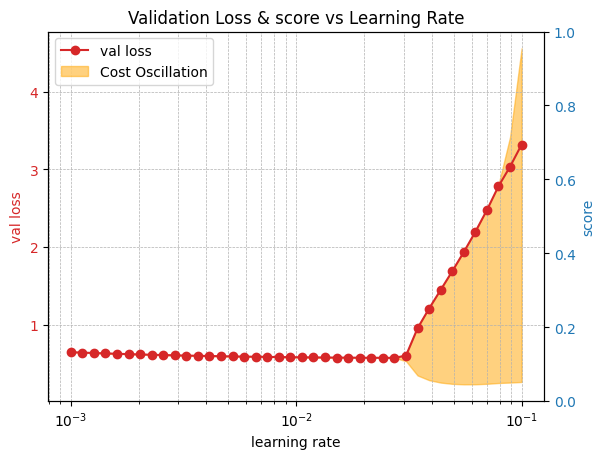

In [126]:
lrs = np.logspace(start=-3, stop=-1, num=40)
_ = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, class_weight=ratio, to_plot=True, iterations=200)

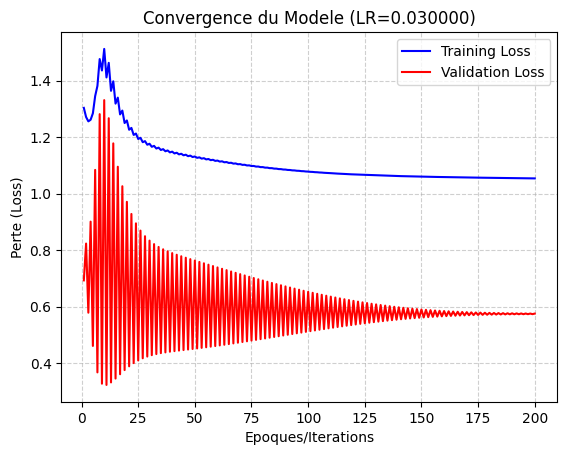

In [127]:
plot_tools.plot_convergence(X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=0.03, iterations=200, class_weight=ratio)

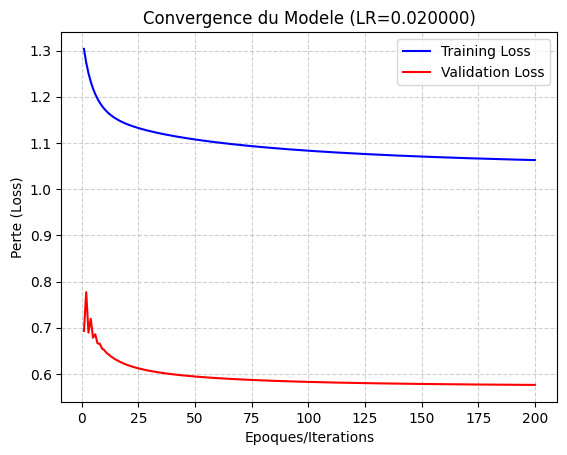

In [128]:
plot_tools.plot_convergence(X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=0.02, iterations=200, class_weight=ratio)

In [129]:
best_lr = 0.02
model_opt = feature_tracker.get_trained_model(learning_rate=best_lr, class_weight=ratio, threshold=model_opt.threshold, iterations=200)
model_opt.top_k_caravan_policy_owners()
model_opt.top_k_caravan_policy_owners(on_train_set=True)

Threshold   : 0.1000
[[   4 1091]
 [   0   70]]
Top 233 contient:         45 positifs
Top 931 contient:         158 positifs


Le threshold est inutile avec ce type d'évaluation, mais je le fais quand même.

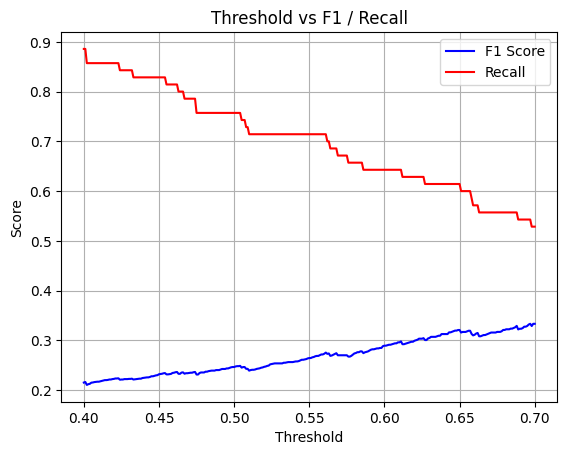

In [130]:
plot_tools.plot_threshold_metrics(model_opt, feature_tracker, range_min=0.4, range_max=0.7, step=0.001, plot_only_recall=False)

In [131]:
model_opt.threshold = 0.56
model_opt

Threshold   : 0.5600
[[849 246]
 [ 20  50]]

### **Régularisation L2**

La régularisation L2 est utilisée afin de réduire le risque de surapprentissage, particulièrement en présence de variables corrélées et de nombreuses interactions. J'ai ajouté les variables **total_** ainsi que tout les variables **MINK***, l'analyse de la $\mathrm{VIF}$ a montré qu’il existait de fortes corrélations entre ces variables, et la régularisation L2 permet donc de mieux stabiliser le modèle.

In [132]:
#lambdas = np.logspace(-6, 1, 5)
# lambdas = np.arange(0, 110, 10)
#lambdas = np.arange(100, 2100, 100)
lambdas = np.arange(300, 500, 20)
lambda_const = logisticRegression.find_best_lambda(lambdas, X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=best_lr, class_weight=ratio, best_thresh=model_opt.threshold, iterations=200, t_opt_by_f1=False)

lambda=300 | T=0.560 | F1=0.2898 | Recall=0.7286
lambda=320 | T=0.560 | F1=0.2898 | Recall=0.7286
lambda=340 | T=0.560 | F1=0.2946 | Recall=0.7429
lambda=360 | T=0.560 | F1=0.2955 | Recall=0.7429
lambda=380 | T=0.560 | F1=0.2994 | Recall=0.7571
lambda=400 | T=0.560 | F1=0.2994 | Recall=0.7571
lambda=420 | T=0.560 | F1=0.2994 | Recall=0.7571
lambda=440 | T=0.560 | F1=0.2994 | Recall=0.7571
lambda=460 | T=0.560 | F1=0.2994 | Recall=0.7571
lambda=480 | T=0.560 | F1=0.2986 | Recall=0.7571

Best lambda (F1): 380
Best threshold: 0.560
Best F1: 0.2994
Recall: 0.7571

Best lambda (Recall): 380
Best Recall : 0.7571
F1 : 0.2994


In [133]:
lambda_const = 380

In [134]:
model_opt = feature_tracker.get_trained_model(iterations=200, learning_rate=best_lr, class_weight=ratio, threshold=model_opt.threshold, l2_reg=True, lambda_const=lambda_const)

Threshold   : 0.5600
[[864 231]
 [ 17  53]]


In [135]:
model_opt.top_k_caravan_policy_owners()
model_opt.top_k_caravan_policy_owners(on_train_set=True)

Top 233 contient:         45 positifs
Top 931 contient:         157 positifs


In [136]:
config_model_opt = model_config.ModelConfig(
    threshold=model_opt.threshold,
    class_weight=ratio,
    learning_rate=best_lr,
    iterations=200,
    l2_reg=True,
    lambda_const=lambda_const
)
config_model_opt

ModelConfig(threshold=0.56, class_weight=np.float64(15.748201438848922), learning_rate=0.02, iterations=200, l2_reg=True, l1_reg=False, lambda_const=380)

In [137]:
model_opt = feature_tracker.get_trained_model(**config_model_opt.as_dict(), name="Model opt")

Threshold   : 0.5600
[[864 231]
 [ 17  53]]


In [138]:
feature_tracker.get_features_cols()

['is_PPERSAUT_6xMFALLEEN',
 'total_third_party_policies',
 'total_daily_vehicle_policies',
 'MINK4575',
 'total_leisure_vehicle_policies',
 'MINK123M',
 'PPERSAUTx_is_PBRAND_3_4',
 'PPERSAUT_6xMKOOPKLA',
 'PPERSAUTxMHKOOP_geq_6',
 'total_property_policies',
 'MINKGEM',
 'total_life_health_policies',
 'total_work_heavy_vehicle_policies',
 'PPERSAUTxis_low_no_religion_area',
 'MINK7512']

# Résultat final

In [139]:
X_eval, y_eval = feature_tracker.make_split_eval_data(cols=model_opt.cols)
model_opt.X_eval = X_eval
model_opt.y_eval = y_eval

Le set d'évaluation contient 4000 clients. Le top $800$ du modèle contient **$$\text{Top } k = 115$$** Donc **115** clients avec **CARAVAN** $= 1$.

In [140]:
model_opt.top_k_eval_final()

115

In [141]:
model_opt.cols

Index(['MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MGODRK', 'MGODPR', 'MGODGE',
       'MRELGE', 'MRELSA', 'MFALLEEN', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD',
       'MBERHOOG', 'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MSKB1',
       'MSKB2', 'MSKD', 'MHKOOP', 'MAUT1', 'MAUT2', 'MZPART', 'MKOOPKLA',
       'PWAPART', 'PWABEDR', 'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO',
       'PVRAAUT', 'PAANHANG', 'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN',
       'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND', 'PPLEZIER', 'PFIETS',
       'PINBOED', 'PBYSTAND', 'MOSTYPE_2', 'MOSTYPE_3', 'MOSTYPE_4',
       'MOSTYPE_5', 'MOSTYPE_20', 'MOSTYPE_26', 'MOSTYPE_27', 'MOSTYPE_41',
       'is_PPERSAUT_6xMFALLEEN', 'PPERSAUTxis_low_no_religion_area',
       'PPERSAUTx_is_PBRAND_3_4', 'PPERSAUTxMHKOOP_geq_6',
       'PPERSAUT_6xMKOOPKLA', 'MINK123M', 'MINKGEM', 'MINK7512', 'MINK4575',
       'total_third_party_policies', 'total_daily_vehicle_policies',
       'total_leisure_vehicle_policies', 'total_property_policies'